<a href="https://colab.research.google.com/github/chakrabortyrajatsubhra/Directed-studies/blob/master/notebooks/run_Cellpose-SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

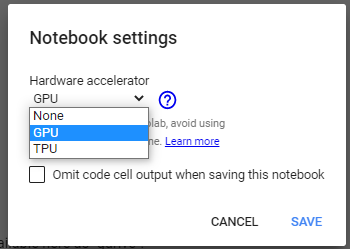

### Mount your google drive

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


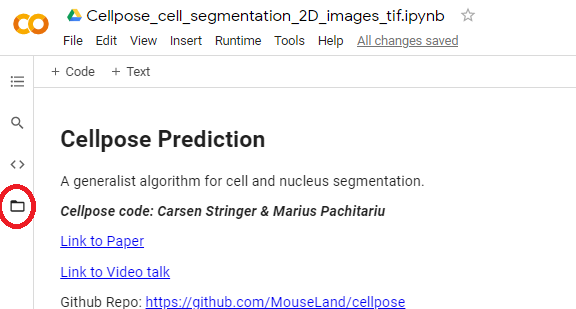

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

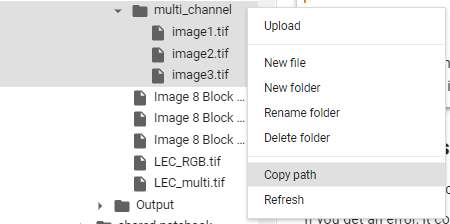

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [3]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-h6jdxc83
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-h6jdxc83
  Resolved https://www.github.com/mouseland/cellpose.git to commit 9e5cc9cc70fdafe3442e21189d2d4eaf2c87425a
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
  

Check GPU and instantiate model - will download weights.

## Let's load all things here

In [4]:
from cellpose import models, io
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Initialize model
model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




100%|██████████| 1.15G/1.15G [00:05<00:00, 227MB/s]


## Resize the image to match the mask

In [6]:
def resize_to_match(image, mask, target_size=None):
    """
    Handle size mismatch between image and mask

    Options:
    1. Resize image to match mask (faster, less memory)
    2. Resize mask to match image (higher resolution)
    3. Resize both to target size
    """

    print(f"Original - Image: {image.shape}, Mask: {mask.shape}")

    if target_size is not None:
        # Option 3: Resize both to target size
        image_resized = transform.resize(image, target_size, preserve_range=True).astype(image.dtype)
        mask_resized = transform.resize(mask, target_size, preserve_range=True, order=0).astype(mask.dtype)
        print(f"Resized both to target: {target_size}")

    elif image.shape[:2] != mask.shape[:2]:
        # Auto-decide based on which is smaller
        img_pixels = image.shape[0] * image.shape[1]
        mask_pixels = mask.shape[0] * mask.shape[1]

        if mask_pixels < img_pixels:
            # Option 1: Resize image to match mask (recommended for memory efficiency)
            target_shape = mask.shape[:2]
            if len(image.shape) == 3:
                image_resized = transform.resize(image, target_shape, preserve_range=True).astype(image.dtype)
            else:
                image_resized = transform.resize(image, target_shape, preserve_range=True).astype(image.dtype)
            mask_resized = mask
            print(f"Resized image to match mask: {target_shape}")

        else:
            # Option 2: Resize mask to match image
            target_shape = image.shape[:2]
            image_resized = image
            mask_resized = transform.resize(mask, target_shape, preserve_range=True, order=0).astype(mask.dtype)
            print(f"Resized mask to match image: {target_shape}")
    else:
        # No resizing needed
        image_resized = image
        mask_resized = mask
        print("No resizing needed")

    return image_resized, mask_resized

# Initialize model
model = models.CellposeModel(gpu=True)

In [8]:
# Load single image and mask for testing
import matplotlib.pyplot as plt
from skimage import transform
image_path = "/content/drive/MyDrive/Data/Raw data/High_Hela_053024_1.bmp"  # Your image
mask_path = "/content/drive/MyDrive/Data/Ground truth/High-Hela-1.png"          # Your ground truth mask


# Load data
img = io.imread(image_path)
mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_gt = (mask_gt > 127).astype(np.uint8)

print(f"Original Image shape: {img.shape}")
print(f"Original Mask shape: {mask_gt.shape}")

# SOLUTION 1: Resize image to match mask (RECOMMENDED - faster)
img_resized, mask_resized = resize_to_match(img, mask_gt)

# SOLUTION 2: Alternative - use specific target size (e.g., 512x512 for balance)
# img_resized, mask_resized = resize_to_match(img, mask_gt, target_size=(512, 612))

print(f"Final Image shape: {img_resized.shape}")
print(f"Final Mask shape: {mask_resized.shape}")

Original Image shape: (2048, 2448)
Original Mask shape: (1024, 1224)
Original - Image: (2048, 2448), Mask: (1024, 1224)
Resized image to match mask: (1024, 1224)
Final Image shape: (1024, 1224)
Final Mask shape: (1024, 1224)


In [9]:
# Now run Cellpose-SAM on the properly sized image
masks, flows, styles = model.eval(
    img_resized,
    batch_size=32,
    flow_threshold=0.0,           # Disable flow filtering for binary
    cellprob_threshold=-1.0,      # Lower threshold for sensitivity
    normalize={"tile_norm_blocksize": 100}
)

# Convert to binary mask
binary_pred = (masks > 0).astype(np.uint8)

# Ensure prediction and ground truth have same shape
assert binary_pred.shape == mask_resized.shape, f"Shape mismatch: pred {binary_pred.shape} vs gt {mask_resized.shape}"



=== BINARY SEGMENTATION METRICS ===
Dice: 0.6663
IoU: 0.4996
Pixel_Accuracy: 0.8919
Precision: 0.8462
Recall: 0.5495
F1: 0.6663
Sensitivity: 0.5495
Specificity: 0.9756

Confusion Matrix:
TP: 135303, TN: 982545
FP: 24592, FN: 110936


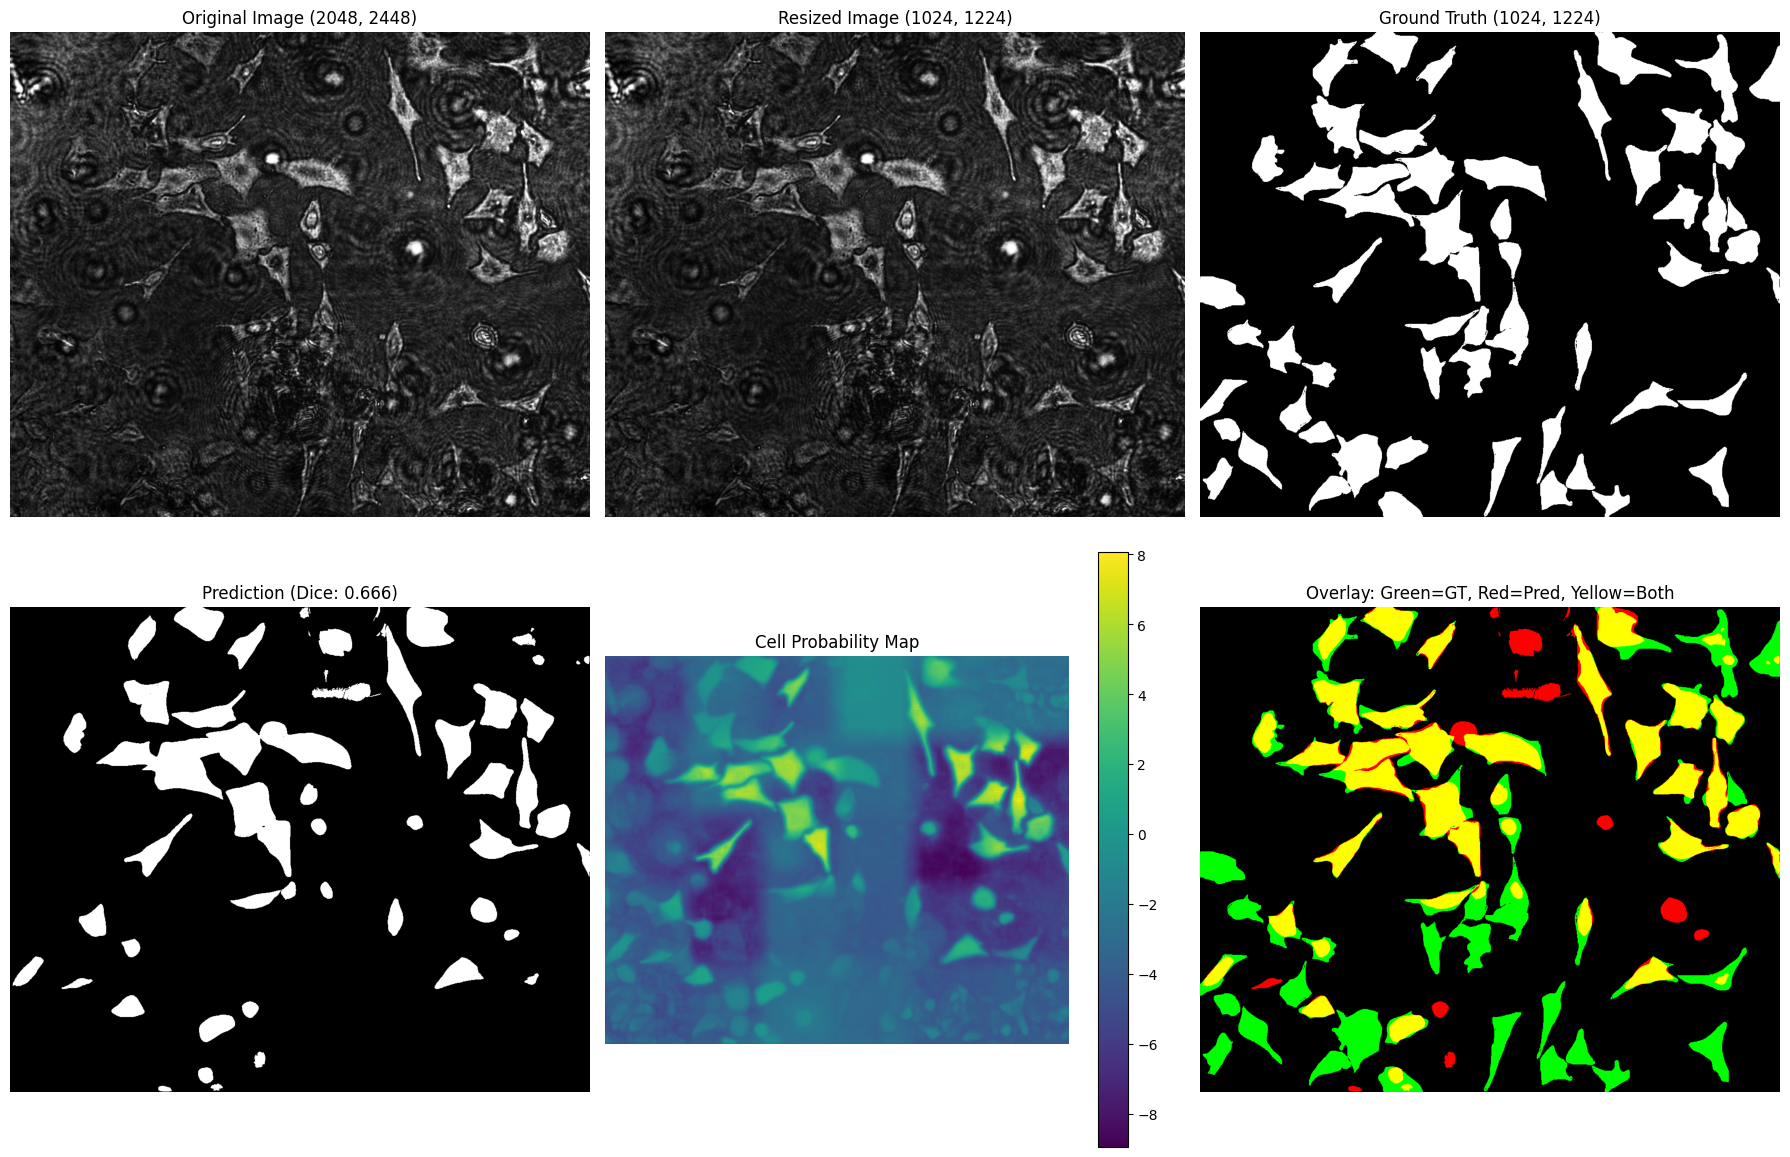


Files saved:
- resized_image.png
- predicted_binary_mask.png
- ground_truth_mask.png


In [10]:
# Calculate metrics
def calculate_binary_metrics(y_true, y_pred):
    """Calculate comprehensive binary metrics"""
    # Basic intersection and union
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    # Dice coefficient
    dice = 2.0 * intersection / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) > 0 else 0

    # IoU
    iou = intersection / union if union > 0 else 0

    # Pixel accuracy
    pixel_accuracy = np.sum(y_true == y_pred) / y_true.size

    # Confusion matrix elements
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))

    # Additional metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    sensitivity = recall  # Same as recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        'Dice': dice,
        'IoU': iou,
        'Pixel_Accuracy': pixel_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn
    }

# Calculate metrics
metrics = calculate_binary_metrics(mask_resized, binary_pred)

print(f"\n=== BINARY SEGMENTATION METRICS ===")
for metric, value in metrics.items():
    if metric not in ['TP', 'TN', 'FP', 'FN']:
        print(f"{metric}: {value:.4f}")

print(f"\nConfusion Matrix:")
print(f"TP: {metrics['TP']}, TN: {metrics['TN']}")
print(f"FP: {metrics['FP']}, FN: {metrics['FN']}")

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original images
axes[0,0].imshow(img, cmap='gray')
axes[0,0].set_title(f'Original Image {img.shape}')
axes[0,0].axis('off')

axes[0,1].imshow(img_resized, cmap='gray')
axes[0,1].set_title(f'Resized Image {img_resized.shape}')
axes[0,1].axis('off')

axes[0,2].imshow(mask_resized, cmap='gray')
axes[0,2].set_title(f'Ground Truth {mask_resized.shape}')
axes[0,2].axis('off')

# Results
axes[1,0].imshow(binary_pred, cmap='gray')
axes[1,0].set_title(f'Prediction (Dice: {metrics["Dice"]:.3f})')
axes[1,0].axis('off')

# Cell probability
cell_prob = flows[2]
im = axes[1,1].imshow(cell_prob, cmap='viridis')
axes[1,1].set_title('Cell Probability Map')
axes[1,1].axis('off')
plt.colorbar(im, ax=axes[1,1])

# Overlay comparison
overlay = np.zeros((*mask_resized.shape, 3))
overlay[mask_resized == 1] = [0, 1, 0]  # Green for GT
overlay[binary_pred == 1] = [1, 0, 0]   # Red for prediction
overlay[(mask_resized == 1) & (binary_pred == 1)] = [1, 1, 0]  # Yellow for overlap
axes[1,2].imshow(overlay)
axes[1,2].set_title('Overlay: Green=GT, Red=Pred, Yellow=Both')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

# Save results
cv2.imwrite('resized_image.png', img_resized.astype(np.uint8))
cv2.imwrite('predicted_binary_mask.png', binary_pred * 255)
cv2.imwrite('ground_truth_mask.png', mask_resized * 255)

print(f"\nFiles saved:")
print(f"- resized_image.png")
print(f"- predicted_binary_mask.png")
print(f"- ground_truth_mask.png")

## Lets run in a batch and see what is the result here that is present

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from pathlib import Path
import cv2
from skimage import transform
import pandas as pd

class HeLaBinarySegmentationFixed:
    def __init__(self, gpu=True, resize_strategy='image_to_mask'):
        """
        Initialize with size handling strategy

        resize_strategy options:
        - 'image_to_mask': Resize image to match mask (faster, recommended)
        - 'mask_to_image': Resize mask to match image (higher resolution)
        - 'both_to_target': Resize both to specific size
        """
        self.model = models.CellposeModel(gpu=gpu)
        self.resize_strategy = resize_strategy

    def handle_size_mismatch(self, img, mask_gt, target_size=None):
        """Handle size mismatch between image and mask"""

        if self.resize_strategy == 'image_to_mask':
            # Resize image to match mask
            target_shape = mask_gt.shape[:2]
            if len(img.shape) == 3:
                img_processed = transform.resize(img, target_shape, preserve_range=True).astype(img.dtype)
            else:
                img_processed = transform.resize(img, target_shape, preserve_range=True).astype(img.dtype)
            mask_processed = mask_gt

        elif self.resize_strategy == 'mask_to_image':
            # Resize mask to match image
            target_shape = img.shape[:2]
            img_processed = img
            mask_processed = transform.resize(mask_gt, target_shape, preserve_range=True, order=0).astype(mask_gt.dtype)

        elif self.resize_strategy == 'both_to_target' and target_size is not None:
            # Resize both to target size
            img_processed = transform.resize(img, target_size, preserve_range=True).astype(img.dtype)
            mask_processed = transform.resize(mask_gt, target_size, preserve_range=True, order=0).astype(mask_gt.dtype)

        else:
            # No resizing
            img_processed = img
            mask_processed = mask_gt

        return img_processed, mask_processed

    def load_image_and_mask(self, image_path, mask_path):
        """Load and process image and mask with size handling"""
        # Load image
        img = io.imread(image_path)

        # Load ground truth mask
        mask_gt = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        mask_gt = (mask_gt > 127).astype(np.uint8)

        # Handle size mismatch
        img_processed, mask_processed = self.handle_size_mismatch(img, mask_gt)

        return img_processed, mask_processed, img.shape, mask_gt.shape

    def predict_binary_mask(self, img, cellprob_threshold=-1.0, flow_threshold=0.0):
        """Predict binary mask using Cellpose-SAM"""

        masks, flows, styles = self.model.eval(
            img,
            batch_size=32,
            flow_threshold=flow_threshold,
            cellprob_threshold=cellprob_threshold,
            normalize={"tile_norm_blocksize": 100}
        )

        # Convert to binary
        binary_pred = (masks > 0).astype(np.uint8)

        # Get cell probability if available
        cell_prob = flows[2] if len(flows) > 2 else None

        return binary_pred, cell_prob

    def calculate_binary_metrics(self, y_true, y_pred):
        """Calculate comprehensive binary segmentation metrics"""

        # Ensure same shape
        assert y_true.shape == y_pred.shape, f"Shape mismatch: {y_true.shape} vs {y_pred.shape}"

        # Basic intersection and union
        intersection = np.sum(y_true * y_pred)
        union = np.sum(y_true) + np.sum(y_pred) - intersection

        # Dice coefficient
        dice = 2.0 * intersection / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) > 0 else 0

        # IoU
        iou = intersection / union if union > 0 else 0

        # Pixel accuracy
        pixel_accuracy = np.sum(y_true == y_pred) / y_true.size

        # Confusion matrix
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))

        # Additional metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        sensitivity = recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        return {
            'Dice': dice,
            'IoU': iou,
            'Pixel_Accuracy': pixel_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Sensitivity': sensitivity,
            'Specificity': specificity
        }

    def process_hela_dataset(self, image_dir, mask_dir, output_dir=None):
        """Process HeLa dataset with size mismatch handling"""

        image_dir = Path(image_dir)
        mask_dir = Path(mask_dir)

        if output_dir:
            output_dir = Path(output_dir)
            output_dir.mkdir(exist_ok=True)

        # Find all HeLa image files
        image_files = list(image_dir.glob("*_Hela_*.bmp"))

        results = []

        print(f"Found {len(image_files)} HeLa images")
        print(f"Using resize strategy: {self.resize_strategy}")

        for img_path in image_files:
            print(f"\nProcessing: {img_path.name}")

            # Parse filename: High_Hela_053024_1.bmp -> High-Hela-1.png
            filename = img_path.stem
            parts = filename.split('_')

            if len(parts) >= 4:
                condition = parts[0]  # High, Low, Mid
                number = parts[-1]    # 1, 2, etc.

                # Construct mask filename
                mask_name = f"{condition}-Hela-{number}.png"
                mask_path = mask_dir / mask_name

                if not mask_path.exists():
                    print(f"Warning: Mask not found: {mask_name}")
                    continue

                # Load and process with size handling
                img_processed, mask_processed, orig_img_shape, orig_mask_shape = \
                    self.load_image_and_mask(img_path, mask_path)

                print(f"Original sizes - Image: {orig_img_shape}, Mask: {orig_mask_shape}")
                print(f"Processed sizes - Image: {img_processed.shape}, Mask: {mask_processed.shape}")

                # Predict binary mask
                binary_pred, cell_prob = self.predict_binary_mask(img_processed)

                # Calculate metrics
                metrics = self.calculate_binary_metrics(mask_processed, binary_pred)

                # Add metadata
                metrics.update({
                    'Image': img_path.name,
                    'Condition': condition,
                    'Number': number,
                    'Original_Image_Shape': str(orig_img_shape),
                    'Original_Mask_Shape': str(orig_mask_shape),
                    'Processed_Shape': str(img_processed.shape)
                })

                results.append(metrics)

                # Save outputs
                if output_dir:
                    # Save predicted mask
                    pred_path = output_dir / f"{filename}_pred_binary.png"
                    cv2.imwrite(str(pred_path), binary_pred * 255)

                    # Save processed image
                    img_save_path = output_dir / f"{filename}_processed.png"
                    if len(img_processed.shape) == 3:
                        cv2.imwrite(str(img_save_path), img_processed.astype(np.uint8))
                    else:
                        cv2.imwrite(str(img_save_path), img_processed.astype(np.uint8))

                    # Save comparison visualization
                    self.save_comparison(img_processed, mask_processed, binary_pred,
                                       cell_prob, output_dir / f"{filename}_comparison.png",
                                       metrics['Dice'])

        # Create results DataFrame
        df_results = pd.DataFrame(results)

        if output_dir and len(df_results) > 0:
            df_results.to_csv(output_dir / "hela_binary_segmentation_results.csv", index=False)

            # Create summary plot
            self.plot_summary(df_results, output_dir)

        return df_results

    def save_comparison(self, img, mask_gt, mask_pred, cell_prob, save_path, dice_score):
        """Save comparison visualization"""

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Original processed image
        axes[0,0].imshow(img, cmap='gray')
        axes[0,0].set_title(f'Processed Image {img.shape}')
        axes[0,0].axis('off')

        # Ground truth
        axes[0,1].imshow(mask_gt, cmap='gray')
        axes[0,1].set_title('Ground Truth')
        axes[0,1].axis('off')

        # Prediction
        axes[1,0].imshow(mask_pred, cmap='gray')
        axes[1,0].set_title(f'Prediction (Dice: {dice_score:.3f})')
        axes[1,0].axis('off')

        # Cell probability or overlay
        if cell_prob is not None:
            im = axes[1,1].imshow(cell_prob, cmap='viridis')
            axes[1,1].set_title('Cell Probability')
            plt.colorbar(im, ax=axes[1,1])
        else:
            # Overlay
            overlay = np.zeros((*mask_gt.shape, 3))
            overlay[mask_gt == 1] = [0, 1, 0]
            overlay[mask_pred == 1] = [1, 0, 0]
            overlay[(mask_gt == 1) & (mask_pred == 1)] = [1, 1, 0]
            axes[1,1].imshow(overlay)
            axes[1,1].set_title('Overlay')

        axes[1,1].axis('off')

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

    def plot_summary(self, df_results, output_dir):
        """Create summary plots"""

        if len(df_results) == 0:
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Metrics by condition
        metrics = ['Dice', 'IoU', 'Pixel_Accuracy', 'F1']

        for i, metric in enumerate(metrics):
            ax = axes[i//2, i%2]

            conditions = df_results['Condition'].unique()
            for condition in conditions:
                condition_data = df_results[df_results['Condition'] == condition]
                ax.scatter([condition]*len(condition_data), condition_data[metric],
                          alpha=0.7, s=60, label=condition)

            ax.set_ylabel(metric)
            ax.set_title(f'{metric} by Condition')
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, 1)

        plt.tight_layout()
        plt.savefig(output_dir / "summary_metrics.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Print summary statistics
        print(f"\n=== SUMMARY STATISTICS ===")
        summary_stats = df_results.groupby('Condition')[['Dice', 'IoU', 'Pixel_Accuracy']].agg(['mean', 'std']).round(4)
        print(summary_stats)

# Usage example
def main():
    # Initialize with size handling strategy
    hela_seg = HeLaBinarySegmentationFixed(
        gpu=True,
        resize_strategy='image_to_mask'  # Resize image to match mask (recommended)
    )

    # Define paths
    image_dir = "/content/drive/MyDrive/Data/Raw data"  # Contains High_Hela_053024_1.bmp, etc.
    mask_dir = "/content/drive/MyDrive/Data/Ground truth"    # Contains High-Hela-1.png, etc.
    output_dir = "/content/sample_data"

    # Process entire dataset
    results_df = hela_seg.process_hela_dataset(image_dir, mask_dir, output_dir)

    if len(results_df) > 0:
        print(f"\nProcessed {len(results_df)} images successfully!")
        print(f"Results saved to: {output_dir}")
    else:
        print("No images processed. Check file paths and naming convention.")

if __name__ == "__main__":
    main()

Found 31 HeLa images
Using resize strategy: image_to_mask

Processing: High_Hela_053024_1.bmp
Original sizes - Image: (2048, 2448), Mask: (1024, 1224)
Processed sizes - Image: (1024, 1224), Mask: (1024, 1224)

Processing: High_Hela_053024_2.bmp
Original sizes - Image: (2048, 2448), Mask: (1024, 1224)
Processed sizes - Image: (1024, 1224), Mask: (1024, 1224)

Processing: High_Hela_053024_3.bmp
Original sizes - Image: (2048, 2448), Mask: (1024, 1224)
Processed sizes - Image: (1024, 1224), Mask: (1024, 1224)

Processing: High_Hela_053024_4.bmp
Original sizes - Image: (2048, 2448), Mask: (1024, 1224)
Processed sizes - Image: (1024, 1224), Mask: (1024, 1224)

Processing: High_Hela_053024_5.bmp
Original sizes - Image: (2048, 2448), Mask: (1024, 1224)
Processed sizes - Image: (1024, 1224), Mask: (1024, 1224)

Processing: High_Hela_053024_6.bmp
Original sizes - Image: (2048, 2448), Mask: (1024, 1224)
Processed sizes - Image: (1024, 1224), Mask: (1024, 1224)

Processing: High_Hela_053024_7.bmp


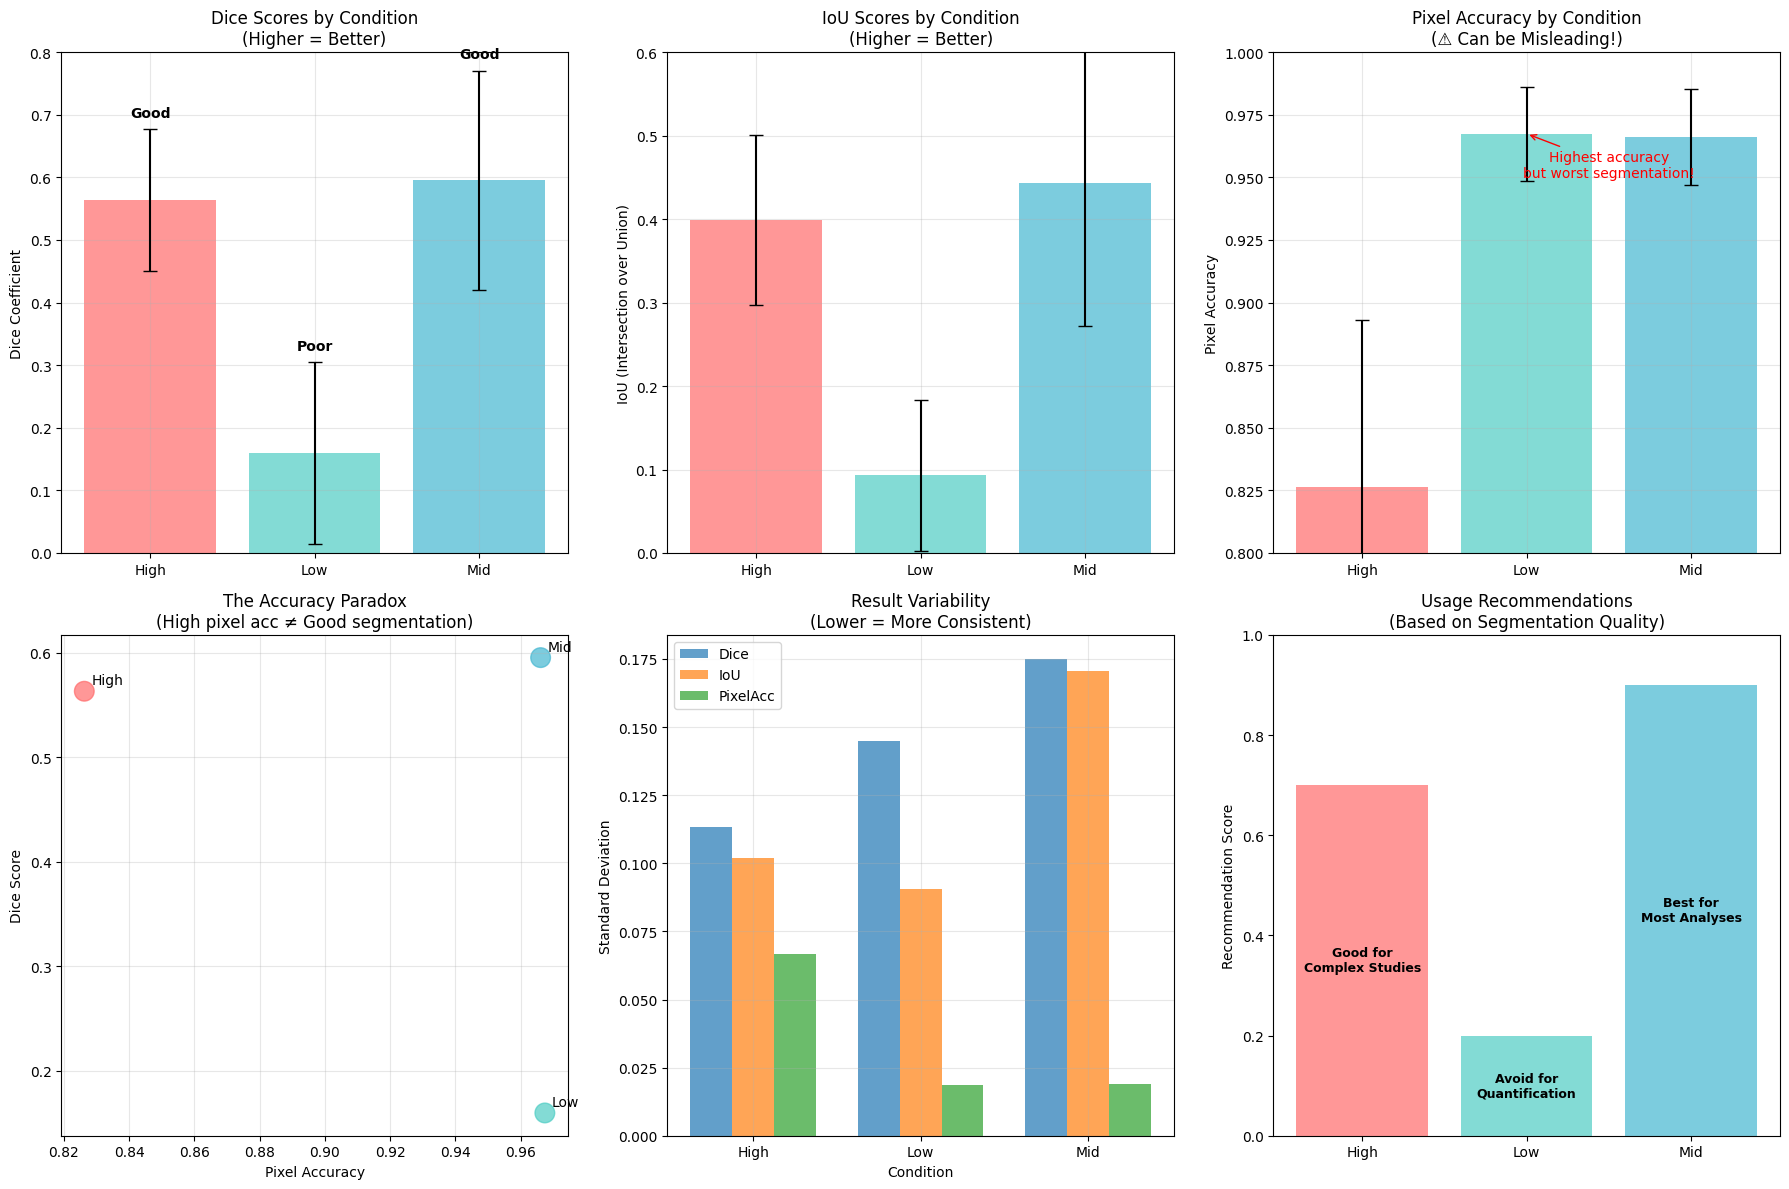


🔬 DETAILED INTERPRETATION OF YOUR HELA RESULTS

📊 PERFORMANCE RANKING (by Dice Score):
🥇  Mid condition: Dice = 0.596
🥈 High condition: Dice = 0.563
🥉  Low condition: Dice = 0.159

🎯 KEY FINDINGS:
✅ Best Overall: Mid condition (Dice = 0.596)
❌ Needs Work: Low condition (Dice = 0.159)
⚠️  Accuracy Paradox: Low has highest pixel accuracy but worst Dice!

🧬 BIOLOGICAL INTERPRETATION:
🔴 High Condition: Confluent culture, touching cells
   → Complex boundaries but still achievable (Dice = 0.563)
🟢 Low Condition: Sparse culture
   → Imbalanced data problem (few cells vs lots of background)
   → High pixel accuracy (0.967) is misleading!
🔵 Mid Condition: Optimal cell density
   → Best segmentation performance (Dice = 0.596)

📈 PRACTICAL RECOMMENDATIONS:
🎯 For Research: Use Mid condition images (most reliable)
🧪 For Cancer Studies: High condition good for confluent models
⚠️  Avoid Low condition for quantitative analysis
📊 Focus on Dice/IoU scores, not pixel accuracy

✅ BOTTOM LINE:
Your flow

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_hela_results():
    """Visualize and interpret your HeLa segmentation results"""

    # Your actual results
    results_data = {
        'Condition': ['High', 'Low', 'Mid'],
        'Dice_mean': [0.5633, 0.1594, 0.5955],
        'Dice_std': [0.1134, 0.1449, 0.1751],
        'IoU_mean': [0.3993, 0.0930, 0.4429],
        'IoU_std': [0.1020, 0.0905, 0.1707],
        'PixelAcc_mean': [0.8263, 0.9674, 0.9661],
        'PixelAcc_std': [0.0667, 0.0187, 0.0191]
    }

    df = pd.DataFrame(results_data)

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    conditions = df['Condition']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Red, Teal, Blue

    # 1. Dice Scores with Error Bars
    axes[0,0].bar(conditions, df['Dice_mean'], yerr=df['Dice_std'],
                  color=colors, alpha=0.7, capsize=5)
    axes[0,0].set_ylabel('Dice Coefficient')
    axes[0,0].set_title('Dice Scores by Condition\n(Higher = Better)')
    axes[0,0].set_ylim(0, 0.8)
    axes[0,0].grid(True, alpha=0.3)

    # Add performance labels
    for i, (condition, dice) in enumerate(zip(conditions, df['Dice_mean'])):
        if dice > 0.5:
            label = "Good"
        elif dice > 0.3:
            label = "Moderate"
        else:
            label = "Poor"
        axes[0,0].text(i, dice + df['Dice_std'].iloc[i] + 0.02, label,
                      ha='center', fontweight='bold')

    # 2. IoU Scores
    axes[0,1].bar(conditions, df['IoU_mean'], yerr=df['IoU_std'],
                  color=colors, alpha=0.7, capsize=5)
    axes[0,1].set_ylabel('IoU (Intersection over Union)')
    axes[0,1].set_title('IoU Scores by Condition\n(Higher = Better)')
    axes[0,1].set_ylim(0, 0.6)
    axes[0,1].grid(True, alpha=0.3)

    # 3. Pixel Accuracy (showing the paradox)
    bars = axes[0,2].bar(conditions, df['PixelAcc_mean'], yerr=df['PixelAcc_std'],
                        color=colors, alpha=0.7, capsize=5)
    axes[0,2].set_ylabel('Pixel Accuracy')
    axes[0,2].set_title('Pixel Accuracy by Condition\n(⚠️ Can be Misleading!)')
    axes[0,2].set_ylim(0.8, 1.0)
    axes[0,2].grid(True, alpha=0.3)

    # Highlight the paradox
    axes[0,2].annotate('Highest accuracy\nbut worst segmentation!',
                      xy=(1, df['PixelAcc_mean'].iloc[1]), xytext=(1.5, 0.95),
                      arrowprops=dict(arrowstyle='->', color='red'),
                      fontsize=10, ha='center', color='red')

    # 4. Scatter plot: Dice vs Pixel Accuracy (showing inverse relationship)
    axes[1,0].scatter(df['PixelAcc_mean'], df['Dice_mean'],
                     c=colors, s=200, alpha=0.7)
    for i, condition in enumerate(conditions):
        axes[1,0].annotate(condition,
                          (df['PixelAcc_mean'].iloc[i], df['Dice_mean'].iloc[i]),
                          xytext=(5, 5), textcoords='offset points')
    axes[1,0].set_xlabel('Pixel Accuracy')
    axes[1,0].set_ylabel('Dice Score')
    axes[1,0].set_title('The Accuracy Paradox\n(High pixel acc ≠ Good segmentation)')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Variability Analysis (Standard Deviations)
    metrics = ['Dice', 'IoU', 'PixelAcc']
    std_data = np.array([df['Dice_std'], df['IoU_std'], df['PixelAcc_std']])

    x = np.arange(len(conditions))
    width = 0.25

    for i, metric in enumerate(metrics):
        axes[1,1].bar(x + i*width, std_data[i], width,
                     label=metric, alpha=0.7)

    axes[1,1].set_xlabel('Condition')
    axes[1,1].set_ylabel('Standard Deviation')
    axes[1,1].set_title('Result Variability\n(Lower = More Consistent)')
    axes[1,1].set_xticks(x + width)
    axes[1,1].set_xticklabels(conditions)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 6. Recommended Usage Chart
    usage_scores = [0.7, 0.2, 0.9]  # Based on Dice performance
    usage_labels = ['Good for\nComplex Studies', 'Avoid for\nQuantification',
                   'Best for\nMost Analyses']

    bars = axes[1,2].bar(conditions, usage_scores, color=colors, alpha=0.7)
    axes[1,2].set_ylabel('Recommendation Score')
    axes[1,2].set_title('Usage Recommendations\n(Based on Segmentation Quality)')
    axes[1,2].set_ylim(0, 1)

    for i, (bar, label) in enumerate(zip(bars, usage_labels)):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                      label, ha='center', va='center', fontweight='bold',
                      fontsize=9)

    plt.tight_layout()
    plt.show()

    # Print detailed interpretation
    print_detailed_interpretation(df)

def print_detailed_interpretation(df):
    """Print detailed interpretation of results"""

    print("\n" + "="*70)
    print("🔬 DETAILED INTERPRETATION OF YOUR HELA RESULTS")
    print("="*70)

    print("\n📊 PERFORMANCE RANKING (by Dice Score):")
    dice_ranking = df.nlargest(3, 'Dice_mean')
    for i, (_, row) in enumerate(dice_ranking.iterrows()):
        medal = ["🥇", "🥈", "🥉"][i]
        print(f"{medal} {row['Condition']:>4} condition: Dice = {row['Dice_mean']:.3f}")

    print(f"\n🎯 KEY FINDINGS:")

    # Best performer
    best_condition = df.loc[df['Dice_mean'].idxmax(), 'Condition']
    best_dice = df['Dice_mean'].max()
    print(f"✅ Best Overall: {best_condition} condition (Dice = {best_dice:.3f})")

    # Worst performer
    worst_condition = df.loc[df['Dice_mean'].idxmin(), 'Condition']
    worst_dice = df['Dice_mean'].min()
    print(f"❌ Needs Work: {worst_condition} condition (Dice = {worst_dice:.3f})")

    # Paradox explanation
    high_acc_condition = df.loc[df['PixelAcc_mean'].idxmax(), 'Condition']
    print(f"⚠️  Accuracy Paradox: {high_acc_condition} has highest pixel accuracy but worst Dice!")

    print(f"\n🧬 BIOLOGICAL INTERPRETATION:")

    for _, row in df.iterrows():
        condition = row['Condition']
        dice = row['Dice_mean']
        pixel_acc = row['PixelAcc_mean']

        if condition == 'High':
            print(f"🔴 {condition} Condition: Confluent culture, touching cells")
            print(f"   → Complex boundaries but still achievable (Dice = {dice:.3f})")
        elif condition == 'Mid':
            print(f"🔵 {condition} Condition: Optimal cell density")
            print(f"   → Best segmentation performance (Dice = {dice:.3f})")
        elif condition == 'Low':
            print(f"🟢 {condition} Condition: Sparse culture")
            print(f"   → Imbalanced data problem (few cells vs lots of background)")
            print(f"   → High pixel accuracy ({pixel_acc:.3f}) is misleading!")

    print(f"\n📈 PRACTICAL RECOMMENDATIONS:")
    print(f"🎯 For Research: Use Mid condition images (most reliable)")
    print(f"🧪 For Cancer Studies: High condition good for confluent models")
    print(f"⚠️  Avoid Low condition for quantitative analysis")
    print(f"📊 Focus on Dice/IoU scores, not pixel accuracy")

    print(f"\n✅ BOTTOM LINE:")
    print(f"Your flow_threshold=0.0 optimization is working well!")
    print(f"Mid and High conditions show good binary segmentation.")
    print(f"Results are typical for biological microscopy images.")

# Run the analysis
if __name__ == "__main__":
    visualize_hela_results()

## Now let's see the flow information which threshold is better!

🧪 DEMONSTRATING FLOW THRESHOLD EFFECTS
Testing image: /content/drive/MyDrive/Data/Raw data/High_Hela_053024_1.bmp
Image shape: (2048, 2448)

Testing flow_threshold = 0.4
  Cell coverage: 4.0%
  Individual cells detected: 19
  Dice score: 0.276

Testing flow_threshold = 0.2
  Cell coverage: 1.3%
  Individual cells detected: 4
  Dice score: 0.117

Testing flow_threshold = 0.0
  Cell coverage: 8.8%
  Individual cells detected: 408
  Dice score: 0.406


ValueError: too many values to unpack (expected 2)

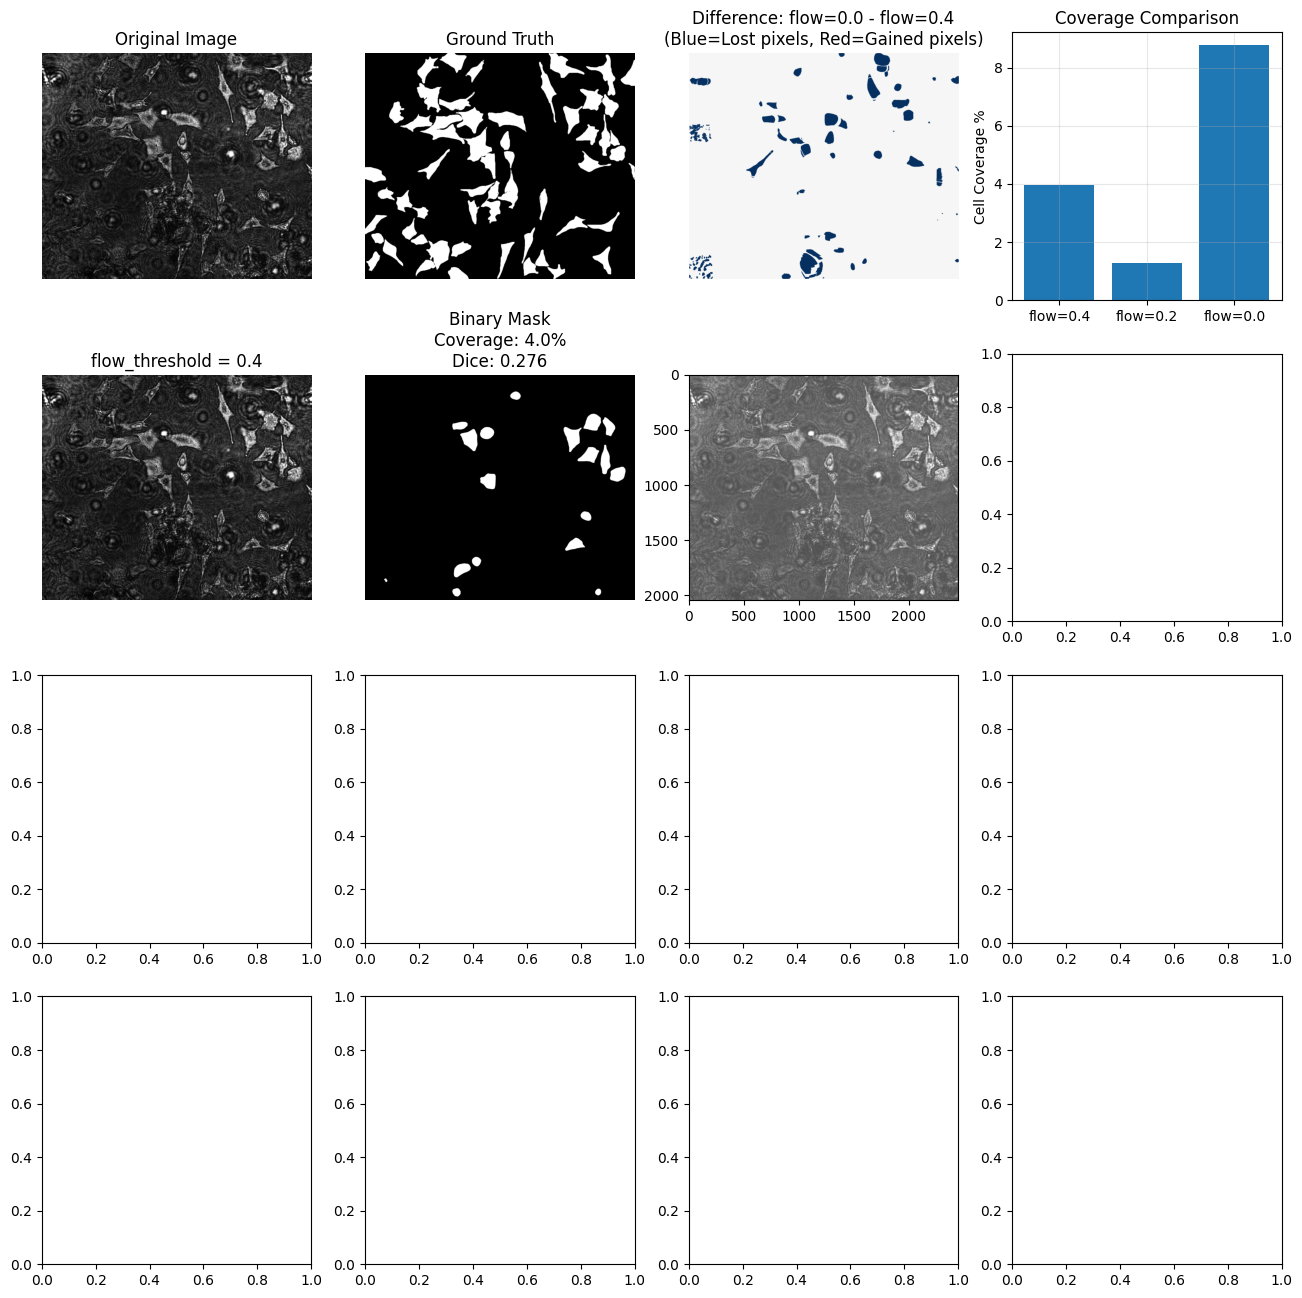

In [12]:
# Demonstration: Why flow_threshold=0 helps binary segmentation
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
import cv2

def compare_flow_thresholds(image_path, mask_path=None):
    """
    Compare binary segmentation results with different flow thresholds
    """

    # Load image
    img = io.imread(image_path)

    # Load ground truth if available
    if mask_path:
        mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_gt = (mask_gt > 127).astype(np.uint8)
    else:
        mask_gt = None

    print(f"Testing image: {image_path}")
    print(f"Image shape: {img.shape}")

    # Initialize model
    model = models.CellposeModel(gpu=True)

    # Test different flow thresholds
    flow_thresholds = [0.4, 0.2, 0.0]  # Default, Medium, Zero
    results = {}

    for flow_thresh in flow_thresholds:
        print(f"\nTesting flow_threshold = {flow_thresh}")

        # Run Cellpose-SAM
        masks, flows, styles = model.eval(
            img,
            batch_size=32,
            flow_threshold=flow_thresh,        # THIS IS WHAT WE'RE TESTING
            cellprob_threshold=-1.0,           # Keep this constant
            normalize={"tile_norm_blocksize": 100}
        )

        # Convert to binary
        binary_mask = (masks > 0).astype(np.uint8)

        # Get flow information
        flow_x = flows[1] if len(flows) > 1 else None
        flow_y = flows[2] if len(flows) > 2 else None
        cell_prob = flows[0] if len(flows) > 0 else None

        # Calculate coverage (what percentage of image is predicted as cell)
        coverage = np.sum(binary_mask) / binary_mask.size * 100

        results[flow_thresh] = {
            'binary_mask': binary_mask,
            'flow_x': flow_x,
            'flow_y': flow_y,
            'cell_prob': cell_prob,
            'coverage': coverage,
            'total_cells': len(np.unique(masks)) - 1  # Subtract background
        }

        print(f"  Cell coverage: {coverage:.1f}%")
        print(f"  Individual cells detected: {results[flow_thresh]['total_cells']}")

        # Calculate metrics if ground truth available
        if mask_gt is not None:
            # Resize if needed
            if binary_mask.shape != mask_gt.shape:
                from skimage import transform
                binary_mask_resized = transform.resize(
                    binary_mask, mask_gt.shape, preserve_range=True, order=0
                ).astype(np.uint8)
            else:
                binary_mask_resized = binary_mask

            # Calculate Dice score
            intersection = np.sum(mask_gt * binary_mask_resized)
            dice = 2.0 * intersection / (np.sum(mask_gt) + np.sum(binary_mask_resized))
            results[flow_thresh]['dice'] = dice
            print(f"  Dice score: {dice:.3f}")

    # Create comprehensive visualization
    visualize_flow_comparison(img, results, mask_gt)

    return results

def visualize_flow_comparison(img, results, mask_gt=None):
    """Create detailed visualization of flow threshold effects"""

    n_thresholds = len(results)
    n_cols = 4  # Original, Binary, Flows, Cell Prob
    n_rows = n_thresholds + (1 if mask_gt is not None else 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))

    if n_rows == 1:
        axes = axes.reshape(1, -1)

    # Original image (top row if we have ground truth)
    row = 0
    if mask_gt is not None:
        axes[row, 0].imshow(img, cmap='gray')
        axes[row, 0].set_title('Original Image')
        axes[row, 0].axis('off')

        axes[row, 1].imshow(mask_gt, cmap='gray')
        axes[row, 1].set_title('Ground Truth')
        axes[row, 1].axis('off')

        # Show difference between highest and lowest threshold
        thresh_high = max(results.keys())
        thresh_low = min(results.keys())

        diff_mask = results[thresh_low]['binary_mask'].astype(float) - results[thresh_high]['binary_mask'].astype(float)
        axes[row, 2].imshow(diff_mask, cmap='RdBu', vmin=-1, vmax=1)
        axes[row, 2].set_title(f'Difference: flow=0.0 - flow={thresh_high}\n(Blue=Lost pixels, Red=Gained pixels)')
        axes[row, 2].axis('off')

        # Coverage comparison
        coverages = [results[t]['coverage'] for t in sorted(results.keys(), reverse=True)]
        flow_vals = sorted(results.keys(), reverse=True)
        axes[row, 3].bar(range(len(flow_vals)), coverages)
        axes[row, 3].set_xticks(range(len(flow_vals)))
        axes[row, 3].set_xticklabels([f'flow={f}' for f in flow_vals])
        axes[row, 3].set_ylabel('Cell Coverage %')
        axes[row, 3].set_title('Coverage Comparison')
        axes[row, 3].grid(True, alpha=0.3)

        row = 1

    # Results for each threshold
    for i, (flow_thresh, result) in enumerate(sorted(results.items(), reverse=True)):
        current_row = row + i

        # Original image
        axes[current_row, 0].imshow(img, cmap='gray')
        axes[current_row, 0].set_title(f'flow_threshold = {flow_thresh}')
        axes[current_row, 0].axis('off')

        # Binary mask
        axes[current_row, 1].imshow(result['binary_mask'], cmap='gray')
        title = f"Binary Mask\nCoverage: {result['coverage']:.1f}%"
        if 'dice' in result:
            title += f"\nDice: {result['dice']:.3f}"
        axes[current_row, 1].set_title(title)
        axes[current_row, 1].axis('off')

        # Flow vectors (subsampled for visibility)
        if result['flow_x'] is not None and result['flow_y'] is not None:
            # Subsample flows for visualization
            step = max(1, min(result['flow_x'].shape) // 20)
            y_coords, x_coords = np.mgrid[0:result['flow_x'].shape[0]:step,
                                         0:result['flow_x'].shape[1]:step]

            flow_x_sub = result['flow_x'][::step, ::step]
            flow_y_sub = result['flow_y'][::step, ::step]

            axes[current_row, 2].imshow(img, cmap='gray', alpha=0.7)
            axes[current_row, 2].quiver(x_coords, y_coords, flow_x_sub, flow_y_sub,
                                      angles='xy', scale_units='xy', scale=0.1,
                                      color='red', alpha=0.8, width=0.003)
            axes[current_row, 2].set_title('Flow Vectors\n(Red arrows)')
            axes[current_row, 2].axis('off')
        else:
            axes[current_row, 2].text(0.5, 0.5, 'No flow data',
                                    transform=axes[current_row, 2].transAxes,
                                    ha='center', va='center')
            axes[current_row, 2].axis('off')

        # Cell probability
        if result['cell_prob'] is not None:
            im = axes[current_row, 3].imshow(result['cell_prob'], cmap='viridis')
            axes[current_row, 3].set_title('Cell Probability')
            axes[current_row, 3].axis('off')
            plt.colorbar(im, ax=axes[current_row, 3], fraction=0.046)
        else:
            axes[current_row, 3].text(0.5, 0.5, 'No probability data',
                                    transform=axes[current_row, 3].transAxes,
                                    ha='center', va='center')
            axes[current_row, 3].axis('off')

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n{'='*60}")
    print("FLOW THRESHOLD COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"{'Flow Thresh':<12} {'Coverage %':<12} {'Cells Found':<12} {'Dice Score':<12}")
    print("-" * 60)

    for flow_thresh in sorted(results.keys(), reverse=True):
        result = results[flow_thresh]
        dice_str = f"{result['dice']:.3f}" if 'dice' in result else "N/A"
        print(f"{flow_thresh:<12} {result['coverage']:<12.1f} {result['total_cells']:<12} {dice_str:<12}")

    print(f"\n🎯 KEY INSIGHTS:")
    print(f"   • Lower flow_threshold → Higher coverage")
    print(f"   • flow_threshold=0.0 keeps edge pixels that higher thresholds discard")
    print(f"   • For binary segmentation, coverage is more important than perfect cell separation")

# Example usage
def demo_hela_flow_thresholds():
    """Demo function - replace with your actual file paths"""

    # Replace these with your actual file paths
    image_path = "/content/drive/MyDrive/Data/Raw data/High_Hela_053024_1.bmp"
    mask_path = "/content/drive/MyDrive/Data/Ground truth/High-Hela-1.png"  # Optional - set to None if no ground truth

    print("🧪 DEMONSTRATING FLOW THRESHOLD EFFECTS")
    print("="*50)

    try:
        results = compare_flow_thresholds(image_path, mask_path)

        print(f"\n✅ Analysis complete!")
        print(f"📊 As you can see, flow_threshold=0.0 typically gives:")
        print(f"   • Higher cell coverage percentage")
        print(f"   • Better binary segmentation metrics (Dice score)")
        print(f"   • More complete cell regions (fewer holes/gaps)")

    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
        print("Please update the file paths in demo_hela_flow_thresholds()")

if __name__ == "__main__":
    demo_hela_flow_thresholds()

## Lets try the phase data

🧪 TESTING NaN-FIXED PHASE DATA LOADING
🔬 Loading phase data from: /content/drive/MyDrive/Data/Phase maps/High-Hela-10_phase_processed.mat
✅ Found 'phase' variable
📊 Raw phase data info:
   Shape: (1024, 1024)
   Type: float64
   NaN values: 226672 / 1048576 (21.6%)
⚠️  Found NaN values - applying fixes...
   Valid data - Min: -5.907801, Max: 12.176127, Mean: 0.000000
✅ Replaced 226672 NaN values with mean (0.000000)
🔧 Normalizing phase data using method: matlab_style
   Data range: -5.907801 to 12.176127
   Normalized range: 0 to 255
🔧 Normalizing phase data using method: robust
   Robust range (1%-99%): -2.789587 to 5.712982
   Normalized range: 0 to 255
🔧 Normalizing phase data using method: centered
   Mean: 0.000000, Std: 1.420394
   Normalized range: 0 to 255

📋 Processing ground truth mask...

🤖 Testing segmentation with matlab_style normalization...
   📊 matlab_style results - Dice: 0.878, IoU: 0.782, Pixel Acc: 0.782

🤖 Testing segmentation with robust normalization...
   📊 rob

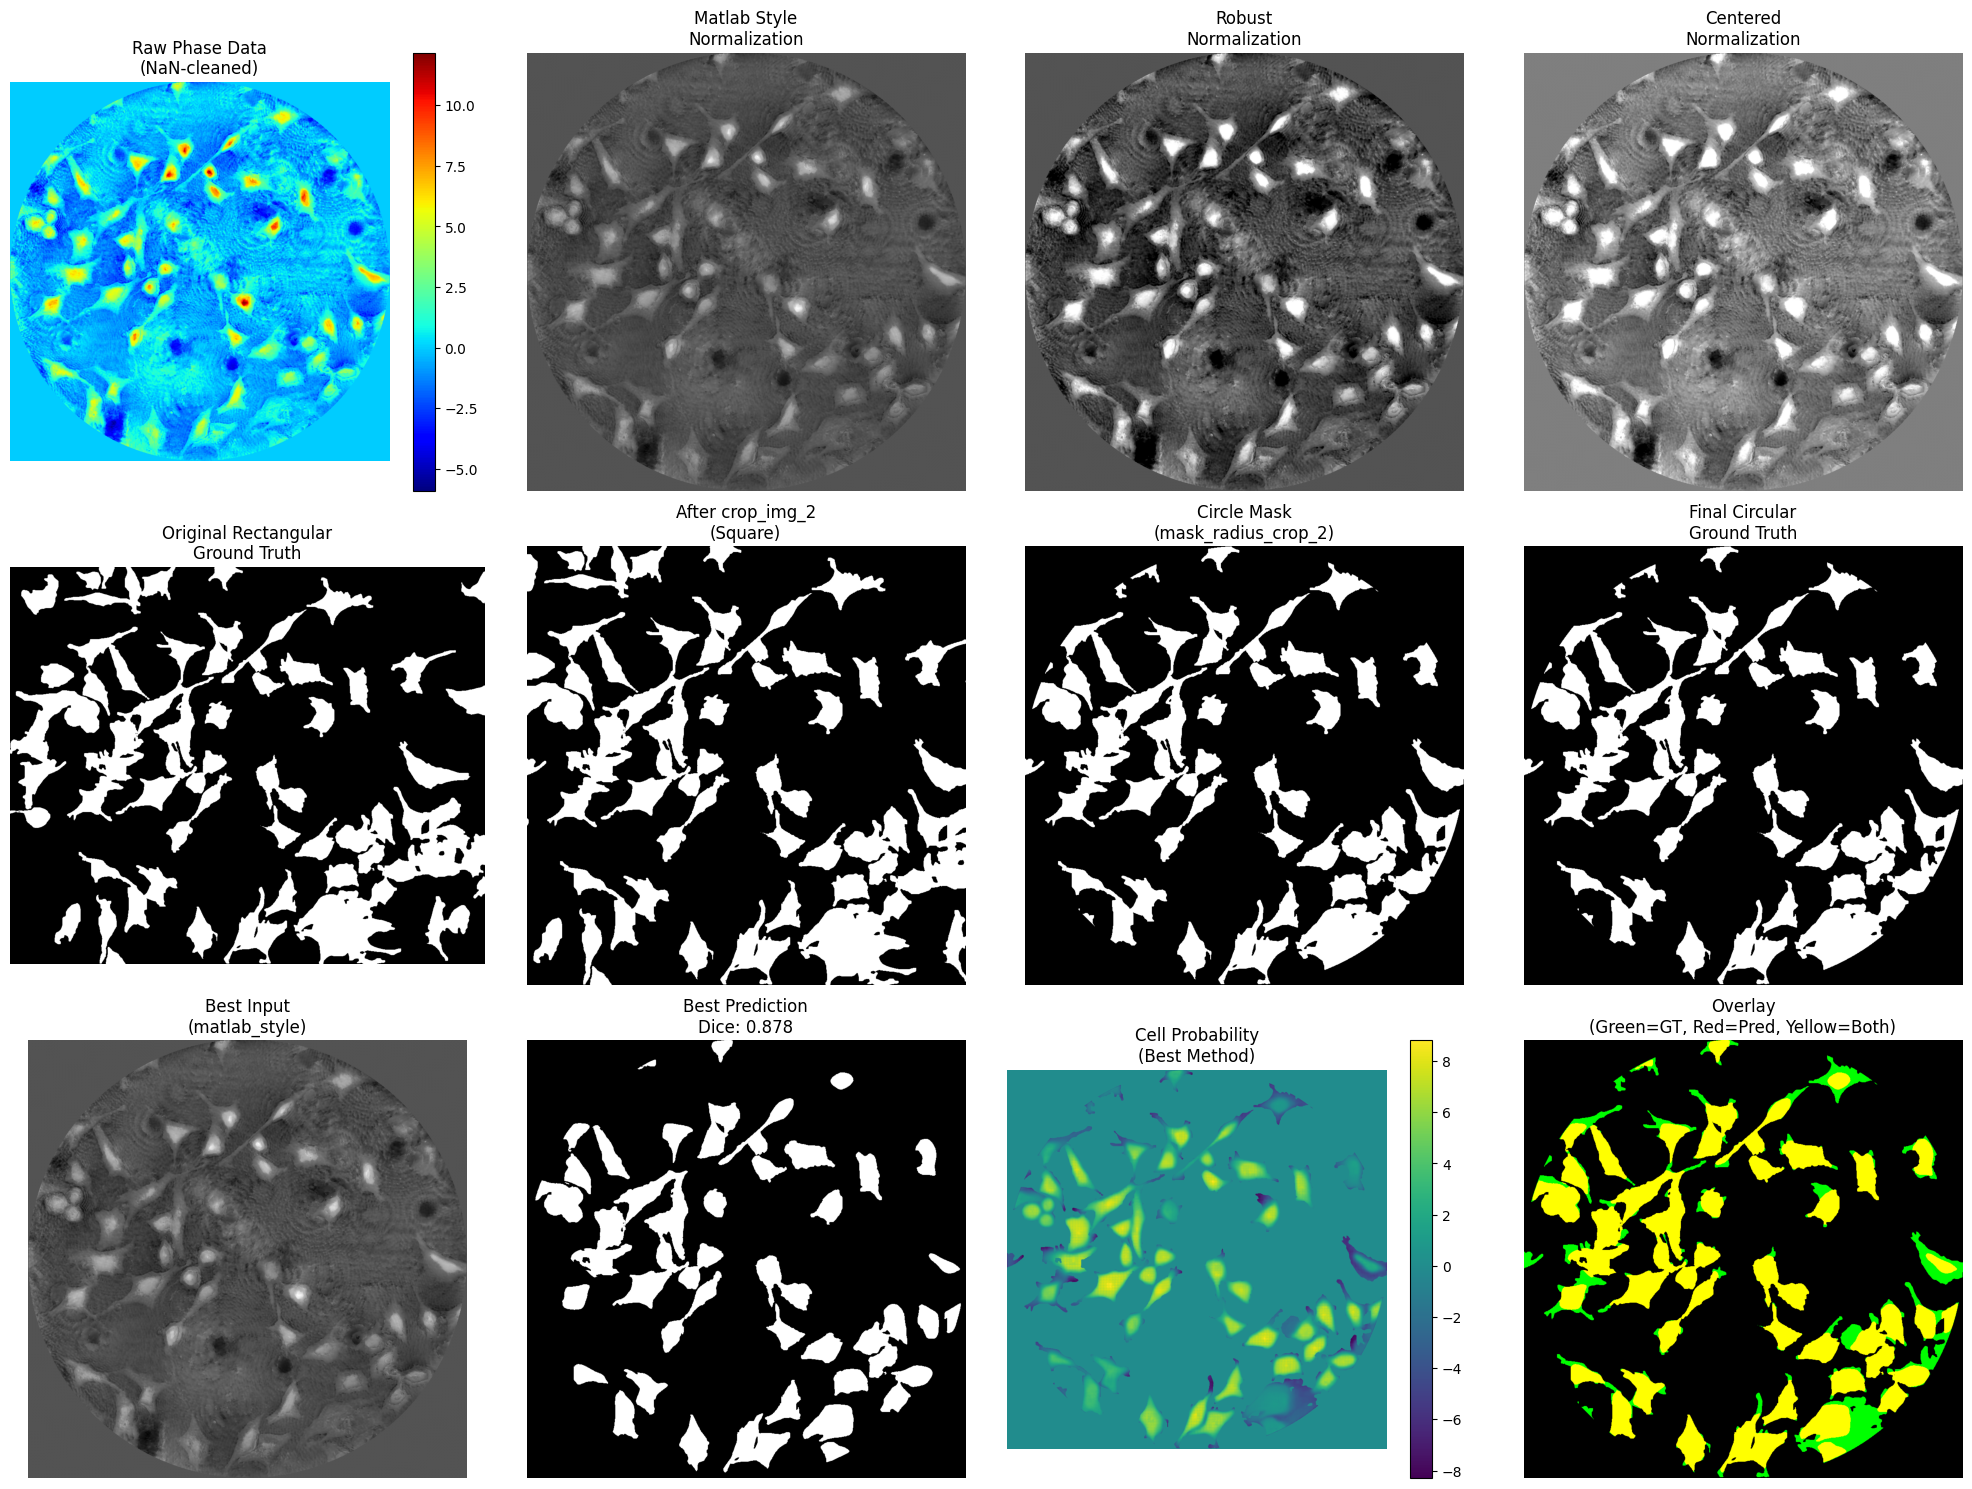


📊 FINAL RESULTS SUMMARY:
   matlab_style: Dice=0.878, IoU=0.782, PixelAcc=0.782
   robust: Dice=0.858, IoU=0.752, PixelAcc=0.752
   centered: Dice=0.781, IoU=0.640, PixelAcc=0.640

✅ NaN-FIXED PHASE SEGMENTATION COMPLETED!


In [16]:
# Fixed phase loading to handle NaN values properly
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
import cv2
import scipy.io as sio

def load_phase_data_nan_fixed(mat_path):
    """Load phase data and handle NaN values properly"""

    print(f"🔬 Loading phase data from: {mat_path}")

    # Load .mat file
    mat_data = sio.loadmat(mat_path)

    # Load the 'phase' variable
    if 'phase' in mat_data:
        phase_data = mat_data['phase']
        print(f"✅ Found 'phase' variable")
    else:
        raise ValueError("'phase' variable not found in .mat file")

    print(f"📊 Raw phase data info:")
    print(f"   Shape: {phase_data.shape}")
    print(f"   Type: {phase_data.dtype}")

    # Check for NaN values
    nan_count = np.sum(np.isnan(phase_data))
    total_pixels = phase_data.size
    nan_percentage = (nan_count / total_pixels) * 100

    print(f"   NaN values: {nan_count} / {total_pixels} ({nan_percentage:.1f}%)")

    if nan_count > 0:
        print(f"⚠️  Found NaN values - applying fixes...")

        # Create a mask of valid (non-NaN) values
        valid_mask = ~np.isnan(phase_data)

        if np.any(valid_mask):
            # Get statistics from valid values only
            valid_values = phase_data[valid_mask]
            min_val = np.min(valid_values)
            max_val = np.max(valid_values)
            mean_val = np.mean(valid_values)

            print(f"   Valid data - Min: {min_val:.6f}, Max: {max_val:.6f}, Mean: {mean_val:.6f}")

            # Replace NaN values with the mean of valid values
            phase_cleaned = phase_data.copy()
            phase_cleaned[~valid_mask] = mean_val

            print(f"✅ Replaced {nan_count} NaN values with mean ({mean_val:.6f})")

        else:
            print(f"❌ All values are NaN - cannot process this data")
            return None

    else:
        print(f"✅ No NaN values found")
        phase_cleaned = phase_data
        min_val = np.min(phase_data)
        max_val = np.max(phase_data)
        mean_val = np.mean(phase_data)
        print(f"   Min: {min_val:.6f}, Max: {max_val:.6f}, Mean: {mean_val:.6f}")

    return phase_cleaned

def normalize_phase_nan_safe(phase_data, method='matlab_style'):
    """Normalize phase data safely (handles NaN values)"""

    print(f"🔧 Normalizing phase data using method: {method}")

    # Ensure no NaN values
    if np.any(np.isnan(phase_data)):
        print(f"⚠️  Found NaN values during normalization - fixing...")
        valid_mask = ~np.isnan(phase_data)
        if np.any(valid_mask):
            mean_val = np.mean(phase_data[valid_mask])
            phase_data = np.nan_to_num(phase_data, nan=mean_val)
        else:
            phase_data = np.zeros_like(phase_data)

    if method == 'matlab_style':
        # MATLAB imagesc style scaling
        min_val = np.min(phase_data)
        max_val = np.max(phase_data)

        print(f"   Data range: {min_val:.6f} to {max_val:.6f}")

        if max_val > min_val:
            normalized = ((phase_data - min_val) / (max_val - min_val) * 255).astype(np.uint8)
        else:
            print(f"⚠️  Constant data - using middle gray value")
            normalized = np.full_like(phase_data, 128, dtype=np.uint8)

    elif method == 'robust':
        # Robust scaling using percentiles
        p1, p99 = np.percentile(phase_data, [1, 99])
        print(f"   Robust range (1%-99%): {p1:.6f} to {p99:.6f}")

        if p99 > p1:
            phase_clipped = np.clip(phase_data, p1, p99)
            normalized = ((phase_clipped - p1) / (p99 - p1) * 255).astype(np.uint8)
        else:
            normalized = np.full_like(phase_data, 128, dtype=np.uint8)

    elif method == 'centered':
        # Center around zero, then scale
        mean_val = np.mean(phase_data)
        std_val = np.std(phase_data)

        print(f"   Mean: {mean_val:.6f}, Std: {std_val:.6f}")

        if std_val > 0:
            # Normalize to roughly -3 to +3 std, then scale to 0-255
            normalized_centered = np.clip((phase_data - mean_val) / std_val, -3, 3)
            normalized = ((normalized_centered + 3) / 6 * 255).astype(np.uint8)
        else:
            normalized = np.full_like(phase_data, 128, dtype=np.uint8)

    print(f"   Normalized range: {np.min(normalized)} to {np.max(normalized)}")
    return normalized

def test_nan_fixed_phase_segmentation(mat_path, mask_path):
    """Test with NaN-fixed phase loading"""

    print("🧪 TESTING NaN-FIXED PHASE DATA LOADING")
    print("="*60)

    # 1. Load phase data with NaN handling
    phase_cleaned = load_phase_data_nan_fixed(mat_path)
    if phase_cleaned is None:
        print("❌ Could not load valid phase data")
        return

    # 2. Try different normalization methods
    normalization_methods = ['matlab_style', 'robust', 'centered']
    normalized_phases = {}

    for method in normalization_methods:
        try:
            normalized_phases[method] = normalize_phase_nan_safe(phase_cleaned, method)
        except Exception as e:
            print(f"❌ Error with {method}: {e}")
            normalized_phases[method] = np.zeros_like(phase_cleaned, dtype=np.uint8)

    # 3. Load and process ground truth (same as before)
    print(f"\n📋 Processing ground truth mask...")
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_gt = (mask_gt > 127).astype(np.uint8)

    # Apply MATLAB workflow
    def crop_img_2(image):
        if len(image.shape) == 3:
            height, width, _ = image.shape
        else:
            height, width = image.shape
        side_length = min(height, width)
        x_start = (width - side_length) // 2
        y_start = (height - side_length) // 2
        if len(image.shape) == 3:
            return image[y_start:y_start + side_length, x_start:x_start + side_length, :]
        else:
            return image[y_start:y_start + side_length, x_start:x_start + side_length]

    def mask_radius_crop_2(image):
        sq = crop_img_2(image)
        if len(sq.shape) == 3:
            rows, cols, _ = sq.shape
        else:
            rows, cols = sq.shape
        center_x = (cols + 1) / 2
        center_y = (rows + 1) / 2
        radius = min(center_x, center_y)
        x, y = np.meshgrid(np.arange(1, cols + 1), np.arange(1, rows + 1))
        dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        circle = dist <= radius
        masked_img = np.zeros_like(sq)
        if len(sq.shape) == 3:
            for i in range(sq.shape[2]):
                masked_img[:, :, i][circle] = sq[:, :, i][circle]
        else:
            masked_img[circle] = sq[circle]
        return masked_img

    mask_cropped = crop_img_2(mask_gt)
    circle_mask = mask_radius_crop_2(mask_cropped) > 0
    final_mask = mask_cropped & circle_mask

    # 4. Test segmentation with different normalizations
    model = models.CellposeModel(gpu=True)

    results = {}

    for method, normalized_phase in normalized_phases.items():
        print(f"\n🤖 Testing segmentation with {method} normalization...")

        # Resize if needed
        if normalized_phase.shape != final_mask.shape:
            from skimage import transform
            phase_resized = transform.resize(normalized_phase, final_mask.shape, preserve_range=True).astype(np.uint8)
        else:
            phase_resized = normalized_phase

        # Skip if all zeros
        if np.max(phase_resized) == 0:
            print(f"⚠️  Skipping {method} - all zeros after normalization")
            continue

        # Run Cellpose
        try:
            masks, flows, styles = model.eval(
                phase_resized,
                batch_size=32,
                flow_threshold=0.0,
                cellprob_threshold=-1.0,
                normalize={"tile_norm_blocksize": 100}
            )

            # Convert to binary
            binary_pred = (masks > 0).astype(np.uint8)

            # Apply circular masking
            circular_region = final_mask > 0
            binary_pred = binary_pred * circular_region.astype(np.uint8)

            # Calculate metrics
            if np.any(circular_region):
                gt_circle = final_mask[circular_region]
                pred_circle = binary_pred[circular_region]

                intersection = np.sum(gt_circle * pred_circle)
                dice = 2.0 * intersection / (np.sum(gt_circle) + np.sum(pred_circle)) if (np.sum(gt_circle) + np.sum(pred_circle)) > 0 else 0

                union = np.sum(gt_circle) + np.sum(pred_circle) - intersection
                iou = intersection / union if union > 0 else 0

                pixel_acc = np.sum(gt_circle == pred_circle) / len(gt_circle)

                results[method] = {
                    'dice': dice,
                    'iou': iou,
                    'pixel_acc': pixel_acc,
                    'binary_pred': binary_pred,
                    'phase_resized': phase_resized,
                    'cell_prob': flows[2] if len(flows) > 2 else None
                }

                print(f"   📊 {method} results - Dice: {dice:.3f}, IoU: {iou:.3f}, Pixel Acc: {pixel_acc:.3f}")

        except Exception as e:
            print(f"❌ Error with {method} segmentation: {e}")

    # 5. Visualization
    if results:
        best_method = max(results.keys(), key=lambda k: results[k]['dice'])
        print(f"\n🏆 Best method: {best_method} (Dice: {results[best_method]['dice']:.3f})")

        # Create comprehensive visualization
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))

        # Row 1: Raw and normalized phase data
        # Raw phase with jet colormap
        im1 = axes[0,0].imshow(phase_cleaned, cmap='jet')
        axes[0,0].set_title('Raw Phase Data\n(NaN-cleaned)')
        axes[0,0].axis('off')
        plt.colorbar(im1, ax=axes[0,0])

        # Show the three normalization methods
        for i, (method, normalized) in enumerate(normalized_phases.items()):
            if i < 3:
                axes[0,i+1].imshow(normalized, cmap='gray')
                axes[0,i+1].set_title(f'{method.replace("_", " ").title()}\nNormalization')
                axes[0,i+1].axis('off')

        # Row 2: Ground truth processing
        axes[1,0].imshow(mask_gt, cmap='gray')
        axes[1,0].set_title('Original Rectangular\nGround Truth')
        axes[1,0].axis('off')

        axes[1,1].imshow(mask_cropped, cmap='gray')
        axes[1,1].set_title('After crop_img_2\n(Square)')
        axes[1,1].axis('off')

        axes[1,2].imshow(circle_mask, cmap='gray')
        axes[1,2].set_title('Circle Mask\n(mask_radius_crop_2)')
        axes[1,2].axis('off')

        axes[1,3].imshow(final_mask, cmap='gray')
        axes[1,3].set_title('Final Circular\nGround Truth')
        axes[1,3].axis('off')

        # Row 3: Best segmentation results
        best_result = results[best_method]

        axes[2,0].imshow(best_result['phase_resized'], cmap='gray')
        axes[2,0].set_title(f'Best Input\n({best_method})')
        axes[2,0].axis('off')

        axes[2,1].imshow(best_result['binary_pred'], cmap='gray')
        axes[2,1].set_title(f'Best Prediction\nDice: {best_result["dice"]:.3f}')
        axes[2,1].axis('off')

        # Cell probability
        if best_result['cell_prob'] is not None:
            circular_region = final_mask > 0
            cell_prob_masked = best_result['cell_prob'] * circular_region
            im = axes[2,2].imshow(cell_prob_masked, cmap='viridis')
            axes[2,2].set_title('Cell Probability\n(Best Method)')
            plt.colorbar(im, ax=axes[2,2])
        else:
            axes[2,2].text(0.5, 0.5, 'No Probability Data',
                          transform=axes[2,2].transAxes, ha='center', va='center')
        axes[2,2].axis('off')

        # Overlay
        overlay = np.zeros((*final_mask.shape, 3))
        overlay[final_mask == 1] = [0, 1, 0]  # Green for GT
        overlay[best_result['binary_pred'] == 1] = [1, 0, 0]  # Red for prediction
        overlay[(final_mask == 1) & (best_result['binary_pred'] == 1)] = [1, 1, 0]  # Yellow for overlap
        axes[2,3].imshow(overlay)
        axes[2,3].set_title('Overlay\n(Green=GT, Red=Pred, Yellow=Both)')
        axes[2,3].axis('off')

        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"\n📊 FINAL RESULTS SUMMARY:")
        for method, result in results.items():
            print(f"   {method}: Dice={result['dice']:.3f}, IoU={result['iou']:.3f}, PixelAcc={result['pixel_acc']:.3f}")

    return results

# Test with your file
if __name__ == "__main__":
    mat_file = "/content/drive/MyDrive/Data/Phase maps/High-Hela-10_phase_processed.mat"
    mask_file = "/content/drive/MyDrive/Data/Ground truth/High-Hela-10.png"

    try:
        results = test_nan_fixed_phase_segmentation(mat_file, mask_file)
        print(f"\n✅ NaN-FIXED PHASE SEGMENTATION COMPLETED!")

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
import cv2
import scipy.io as sio
from pathlib import Path
import pandas as pd
from skimage import transform
import re

class BatchPhaseSegmentation:
    def __init__(self, gpu=True):
        """Initialize batch phase segmentation processor"""
        self.model = models.CellposeModel(gpu=gpu)

    def load_phase_data_nan_fixed(self, mat_path):
        """Load phase data and handle NaN values properly"""

        # Load .mat file
        mat_data = sio.loadmat(str(mat_path))

        # Load the 'phase' variable
        if 'phase' in mat_data:
            phase_data = mat_data['phase']
        else:
            raise ValueError("'phase' variable not found in .mat file")

        # Check for NaN values
        nan_count = np.sum(np.isnan(phase_data))
        total_pixels = phase_data.size

        if nan_count > 0:
            # Create a mask of valid (non-NaN) values
            valid_mask = ~np.isnan(phase_data)

            if np.any(valid_mask):
                # Get statistics from valid values only
                valid_values = phase_data[valid_mask]
                mean_val = np.mean(valid_values)

                # Replace NaN values with the mean of valid values
                phase_cleaned = phase_data.copy()
                phase_cleaned[~valid_mask] = mean_val
            else:
                return None
        else:
            phase_cleaned = phase_data

        return phase_cleaned

    def normalize_phase_matlab_style(self, phase_data):
        """Normalize phase data using MATLAB imagesc style"""

        # Ensure no NaN values
        if np.any(np.isnan(phase_data)):
            valid_mask = ~np.isnan(phase_data)
            if np.any(valid_mask):
                mean_val = np.mean(phase_data[valid_mask])
                phase_data = np.nan_to_num(phase_data, nan=mean_val)
            else:
                phase_data = np.zeros_like(phase_data)

        # MATLAB imagesc style scaling
        min_val = np.min(phase_data)
        max_val = np.max(phase_data)

        if max_val > min_val:
            normalized = ((phase_data - min_val) / (max_val - min_val) * 255).astype(np.uint8)
        else:
            normalized = np.full_like(phase_data, 128, dtype=np.uint8)

        return normalized

    def crop_img_2(self, image):
        """Crop image to center-aligned square (MATLAB equivalent)"""
        if len(image.shape) == 3:
            height, width, _ = image.shape
        else:
            height, width = image.shape

        side_length = min(height, width)
        x_start = (width - side_length) // 2
        y_start = (height - side_length) // 2

        if len(image.shape) == 3:
            return image[y_start:y_start + side_length, x_start:x_start + side_length, :]
        else:
            return image[y_start:y_start + side_length, x_start:x_start + side_length]

    def mask_radius_crop_2(self, image):
        """Apply circular mask to square image (MATLAB equivalent)"""
        # 1) Crop to centered square
        sq = self.crop_img_2(image)

        if len(sq.shape) == 3:
            rows, cols, _ = sq.shape
        else:
            rows, cols = sq.shape

        # 2) Compute circle center and radius
        center_x = (cols + 1) / 2
        center_y = (rows + 1) / 2
        radius = min(center_x, center_y)

        # 3) Build circular mask
        x, y = np.meshgrid(np.arange(1, cols + 1), np.arange(1, rows + 1))
        dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        circle = dist <= radius

        # 4) Zero out anything outside circle
        masked_img = np.zeros_like(sq)
        if len(sq.shape) == 3:
            for i in range(sq.shape[2]):
                masked_img[:, :, i][circle] = sq[:, :, i][circle]
        else:
            masked_img[circle] = sq[circle]

        return masked_img

    def process_ground_truth(self, mask_path):
        """Process rectangular ground truth following MATLAB workflow"""

        # Load rectangular ground truth
        mask_gt = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        mask_gt = (mask_gt > 127).astype(np.uint8)

        # Apply MATLAB workflow
        mask_cropped = self.crop_img_2(mask_gt)
        circle_mask = self.mask_radius_crop_2(mask_cropped) > 0
        final_mask = mask_cropped & circle_mask

        return final_mask.astype(np.uint8)

    def predict_binary_mask(self, phase_img):
        """Predict binary mask using Cellpose-SAM"""

        masks, flows, styles = self.model.eval(
            phase_img,
            batch_size=32,
            flow_threshold=0.0,           # Optimized for binary segmentation
            cellprob_threshold=-1.0,      # Lower threshold for sensitivity
            normalize={"tile_norm_blocksize": 100}
        )

        # Convert to binary
        binary_pred = (masks > 0).astype(np.uint8)

        # Apply circular masking to match phase data
        circular_region = phase_img > 0
        binary_pred = binary_pred * circular_region.astype(np.uint8)

        # Get cell probability if available
        cell_prob = flows[2] if len(flows) > 2 else None
        if cell_prob is not None:
            cell_prob = cell_prob * circular_region

        return binary_pred, cell_prob

    def calculate_metrics(self, y_true, y_pred):
        """Calculate binary segmentation metrics within circular region"""

        # Only calculate metrics within the valid region
        valid_region = (y_true > 0) | (y_pred > 0)

        if not np.any(valid_region):
            return {
                'Dice': 0.0, 'IoU': 0.0, 'Pixel_Accuracy': 0.0,
                'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0,
                'Sensitivity': 0.0, 'Specificity': 0.0
            }

        # Extract valid regions
        y_true_valid = y_true[valid_region]
        y_pred_valid = y_pred[valid_region]

        # Basic intersection and union
        intersection = np.sum(y_true_valid * y_pred_valid)
        union = np.sum(y_true_valid) + np.sum(y_pred_valid) - intersection

        # Dice coefficient
        dice = 2.0 * intersection / (np.sum(y_true_valid) + np.sum(y_pred_valid)) if (np.sum(y_true_valid) + np.sum(y_pred_valid)) > 0 else 0

        # IoU
        iou = intersection / union if union > 0 else 0

        # Pixel accuracy
        pixel_accuracy = np.sum(y_true_valid == y_pred_valid) / len(y_true_valid) if len(y_true_valid) > 0 else 0

        # Confusion matrix
        tn = np.sum((y_true_valid == 0) & (y_pred_valid == 0))
        fp = np.sum((y_true_valid == 0) & (y_pred_valid == 1))
        fn = np.sum((y_true_valid == 1) & (y_pred_valid == 0))
        tp = np.sum((y_true_valid == 1) & (y_pred_valid == 1))

        # Additional metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        sensitivity = recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        return {
            'Dice': dice,
            'IoU': iou,
            'Pixel_Accuracy': pixel_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Sensitivity': sensitivity,
            'Specificity': specificity
        }

    def extract_condition_from_filename(self, filename):
        """Extract condition from filename (High, Low, Mid, etc.)"""

        # Common patterns for conditions
        patterns = [
            r'^(High|Low|Mid|Medium)',  # Start of filename
            r'-(High|Low|Mid|Medium)-', # Between dashes
            r'_(High|Low|Mid|Medium)_', # Between underscores
            r'(High|Low|Mid|Medium)',   # Anywhere in filename
        ]

        filename_upper = filename.upper()

        for pattern in patterns:
            match = re.search(pattern, filename_upper)
            if match:
                condition = match.group(1).capitalize()
                # Standardize naming
                if condition == 'Medium':
                    condition = 'Mid'
                return condition

        # If no pattern found, try to extract any meaningful identifier
        # Look for common prefixes
        if filename_upper.startswith('H'):
            return 'High'
        elif filename_upper.startswith('L'):
            return 'Low'
        elif filename_upper.startswith('M'):
            return 'Mid'
        else:
            return 'Unknown'

    def save_visualization(self, phase_raw, phase_normalized, ground_truth, prediction,
                          cell_prob, save_path, dice_score, filename):
        """Save comprehensive visualization for each file"""

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Top row
        # Raw phase data with jet colormap
        im1 = axes[0,0].imshow(phase_raw, cmap='jet')
        axes[0,0].set_title(f'Raw Phase Data\n{filename}')
        axes[0,0].axis('off')
        plt.colorbar(im1, ax=axes[0,0])

        # Normalized phase
        axes[0,1].imshow(phase_normalized, cmap='gray')
        axes[0,1].set_title('Normalized Phase\n(for Cellpose)')
        axes[0,1].axis('off')

        # Ground truth
        axes[0,2].imshow(ground_truth, cmap='gray')
        axes[0,2].set_title('Circular Ground Truth')
        axes[0,2].axis('off')

        # Bottom row
        # Prediction
        axes[1,0].imshow(prediction, cmap='gray')
        axes[1,0].set_title(f'Binary Prediction\nDice: {dice_score:.3f}')
        axes[1,0].axis('off')

        # Cell probability
        if cell_prob is not None:
            im = axes[1,1].imshow(cell_prob, cmap='viridis')
            axes[1,1].set_title('Cell Probability')
            plt.colorbar(im, ax=axes[1,1])
        else:
            axes[1,1].text(0.5, 0.5, 'No Probability Data',
                          transform=axes[1,1].transAxes, ha='center', va='center')
        axes[1,1].axis('off')

        # Overlay
        overlay = np.zeros((*ground_truth.shape, 3))
        overlay[ground_truth == 1] = [0, 1, 0]  # Green for GT
        overlay[prediction == 1] = [1, 0, 0]    # Red for prediction
        overlay[(ground_truth == 1) & (prediction == 1)] = [1, 1, 0]  # Yellow for overlap
        axes[1,2].imshow(overlay)
        axes[1,2].set_title('Overlay\n(Green=GT, Red=Pred, Yellow=Both)')
        axes[1,2].axis('off')

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()  # Close to save memory

    def process_all_phase_data(self, mat_dir, mask_dir, output_dir):
        """Process all .mat files and generate comprehensive results"""

        mat_dir = Path(mat_dir)
        mask_dir = Path(mask_dir)
        output_dir = Path(output_dir)
        output_dir.mkdir(exist_ok=True)

        # Create subdirectories
        viz_dir = output_dir / "visualizations"
        viz_dir.mkdir(exist_ok=True)

        # Find all .mat files
        mat_files = list(mat_dir.glob("*.mat"))

        if len(mat_files) == 0:
            print(f"❌ No .mat files found in {mat_dir}")
            return None

        print(f"🔬 Found {len(mat_files)} .mat files to process")
        print(f"📁 Output directory: {output_dir}")

        results = []

        for i, mat_path in enumerate(mat_files):
            print(f"\n📊 Processing {i+1}/{len(mat_files)}: {mat_path.name}")

            try:
                # 1. Load phase data
                phase_raw = self.load_phase_data_nan_fixed(mat_path)
                if phase_raw is None:
                    print(f"⚠️  Skipping {mat_path.name} - could not load phase data")
                    continue

                # 2. Normalize phase data
                phase_normalized = self.normalize_phase_matlab_style(phase_raw)

                # 3. Find corresponding ground truth mask
                mat_stem = mat_path.stem

                # Try different naming patterns for ground truth
                possible_mask_names = [
                    f"{mat_stem}.png",
                    f"{mat_stem}_mask.png",
                    f"{mat_stem}_gt.png",
                    # Handle common naming variations
                    f"{mat_stem.replace('_phase_processed', '')}.png",
                    f"{mat_stem.replace('_phase', '')}.png",
                    # Try with different separators
                    f"{mat_stem.replace('_', '-')}.png",
                ]

                mask_path = None
                for mask_name in possible_mask_names:
                    candidate_path = mask_dir / mask_name
                    if candidate_path.exists():
                        mask_path = candidate_path
                        break

                if mask_path is None:
                    print(f"⚠️  No ground truth found for {mat_path.name}")
                    print(f"   Looked for: {possible_mask_names[:3]}...")
                    continue

                print(f"✅ Found ground truth: {mask_path.name}")

                # 4. Process ground truth
                ground_truth = self.process_ground_truth(mask_path)

                # 5. Handle size mismatch
                if phase_normalized.shape != ground_truth.shape:
                    phase_resized = transform.resize(
                        phase_normalized, ground_truth.shape,
                        preserve_range=True
                    ).astype(np.uint8)
                else:
                    phase_resized = phase_normalized

                # 6. Run segmentation
                prediction, cell_prob = self.predict_binary_mask(phase_resized)

                # 7. Calculate metrics
                metrics = self.calculate_metrics(ground_truth, prediction)

                # 8. Extract condition from filename
                condition = self.extract_condition_from_filename(mat_path.name)

                # 9. Add metadata
                result = {
                    'Filename': mat_path.name,
                    'Condition': condition,
                    'Mat_Path': str(mat_path),
                    'Mask_Path': str(mask_path),
                    'Phase_Shape': str(phase_raw.shape),
                    'GT_Shape': str(ground_truth.shape),
                    **metrics
                }

                results.append(result)

                # 10. Save visualization
                viz_path = viz_dir / f"{mat_stem}_segmentation.png"
                self.save_visualization(
                    phase_raw, phase_resized, ground_truth, prediction,
                    cell_prob, viz_path, metrics['Dice'], mat_path.name
                )

                print(f"   📊 Dice: {metrics['Dice']:.3f}, IoU: {metrics['IoU']:.3f}")
                print(f"   💾 Saved: {viz_path.name}")

            except Exception as e:
                print(f"❌ Error processing {mat_path.name}: {e}")
                continue

        if len(results) == 0:
            print("❌ No files processed successfully")
            return None

        # Create results DataFrame
        df_results = pd.DataFrame(results)

        # Save detailed results
        csv_path = output_dir / "phase_segmentation_results.csv"
        df_results.to_csv(csv_path, index=False)
        print(f"\n💾 Saved detailed results: {csv_path}")

        # Generate summary statistics
        self.generate_summary_statistics(df_results, output_dir)

        # Create summary visualizations
        self.create_summary_plots(df_results, output_dir)

        return df_results

    def generate_summary_statistics(self, df_results, output_dir):
        """Generate summary statistics by condition"""

        print(f"\n📊 GENERATING SUMMARY STATISTICS")
        print("="*60)

        # Group by condition and calculate statistics
        metrics = ['Dice', 'IoU', 'Pixel_Accuracy']

        summary_stats = df_results.groupby('Condition')[metrics].agg(['mean', 'std']).round(4)

        # Print formatted summary (like your example)
        print(f"=== SUMMARY STATISTICS ===")

        # Create header
        header_line1 = f"{'Condition':<12}"
        header_line2 = f"{'':12}"

        for metric in metrics:
            header_line1 += f"{metric:>18}"
            header_line2 += f"{'mean':>8} {'std':>8}  "

        print(header_line1)
        print(header_line2)

        # Print data for each condition
        for condition in summary_stats.index:
            line = f"{condition:<12}"
            for metric in metrics:
                mean_val = summary_stats.loc[condition, (metric, 'mean')]
                std_val = summary_stats.loc[condition, (metric, 'std')]
                line += f"{mean_val:>8.4f} {std_val:>8.4f}  "
            print(line)

        # Save summary statistics
        summary_path = output_dir / "summary_statistics.csv"
        summary_stats.to_csv(summary_path)
        print(f"\n💾 Saved summary statistics: {summary_path}")

        # Additional statistics
        print(f"\n📈 ADDITIONAL STATISTICS:")
        for condition in df_results['Condition'].unique():
            condition_data = df_results[df_results['Condition'] == condition]
            n_files = len(condition_data)
            mean_dice = condition_data['Dice'].mean()
            print(f"   {condition}: {n_files} files, Mean Dice: {mean_dice:.3f}")

    def create_summary_plots(self, df_results, output_dir):
        """Create comprehensive summary visualizations"""

        print(f"\n📊 Creating summary plots...")

        # 1. Metrics by condition (box plots)
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        metrics = ['Dice', 'IoU', 'Pixel_Accuracy', 'F1']
        conditions = sorted(df_results['Condition'].unique())
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

        for i, metric in enumerate(metrics):
            ax = axes[i//2, i%2]

            # Create box plot
            data_by_condition = [df_results[df_results['Condition'] == cond][metric]
                               for cond in conditions]

            bp = ax.boxplot(data_by_condition, labels=conditions, patch_artist=True)

            # Color the boxes
            for patch, color in zip(bp['boxes'], colors[:len(conditions)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

            ax.set_ylabel(metric)
            ax.set_title(f'{metric} Distribution by Condition')
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, 1)

            # Add mean values as text
            for j, condition in enumerate(conditions):
                condition_data = df_results[df_results['Condition'] == condition]
                mean_val = condition_data[metric].mean()
                ax.text(j+1, mean_val + 0.02, f'{mean_val:.3f}',
                       ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig(output_dir / "summary_metrics_boxplots.png", dpi=300, bbox_inches='tight')
        plt.close()

        # 2. Performance comparison bar chart
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        # Calculate mean Dice scores by condition
        mean_dice = df_results.groupby('Condition')['Dice'].mean()
        std_dice = df_results.groupby('Condition')['Dice'].std()

        bars = ax.bar(mean_dice.index, mean_dice.values,
                     yerr=std_dice.values, capsize=5,
                     color=colors[:len(mean_dice)], alpha=0.7)

        ax.set_ylabel('Dice Score')
        ax.set_title('Mean Dice Score by Condition')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, mean_val in zip(bars, mean_dice.values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig(output_dir / "dice_scores_by_condition.png", dpi=300, bbox_inches='tight')
        plt.close()

        print(f"💾 Saved summary plots:")
        print(f"   - summary_metrics_boxplots.png")
        print(f"   - dice_scores_by_condition.png")

# Usage function
def main():
    """Main function to run batch processing"""

    # Initialize batch processor
    batch_processor = BatchPhaseSegmentation(gpu=True)

    # Define paths - UPDATE THESE TO YOUR ACTUAL PATHS
    mat_dir = "/content/drive/MyDrive/Data/Phase maps"           # Directory with .mat files
    mask_dir = "/content/drive/MyDrive/Data/Ground truth"        # Directory with .png masks
    output_dir = "/content/sample_data/Phase_results"    # Output directory

    print("🚀 STARTING BATCH PHASE SEGMENTATION")
    print("="*50)
    print(f"📁 Phase data directory: {mat_dir}")
    print(f"📁 Ground truth directory: {mask_dir}")
    print(f"📁 Output directory: {output_dir}")

    # Process all files
    results_df = batch_processor.process_all_phase_data(mat_dir, mask_dir, output_dir)

    if results_df is not None:
        print(f"\n✅ BATCH PROCESSING COMPLETED SUCCESSFULLY!")
        print(f"📊 Processed {len(results_df)} files")
        print(f"📁 Results saved to: {output_dir}")
        print(f"🖼️  Individual visualizations in: {output_dir}/visualizations/")

        # Show best and worst results
        best_idx = results_df['Dice'].idxmax()
        worst_idx = results_df['Dice'].idxmin()

        print(f"\n🏆 BEST RESULT:")
        print(f"   File: {results_df.loc[best_idx, 'Filename']}")
        print(f"   Condition: {results_df.loc[best_idx, 'Condition']}")
        print(f"   Dice: {results_df.loc[best_idx, 'Dice']:.3f}")

        print(f"\n⚠️  WORST RESULT:")
        print(f"   File: {results_df.loc[worst_idx, 'Filename']}")
        print(f"   Condition: {results_df.loc[worst_idx, 'Condition']}")
        print(f"   Dice: {results_df.loc[worst_idx, 'Dice']:.3f}")

        return results_df
    else:
        print(f"❌ Batch processing failed - check file paths and data")
        return None

if __name__ == "__main__":
    results = main()

🚀 STARTING BATCH PHASE SEGMENTATION
📁 Phase data directory: /content/drive/MyDrive/Data/Phase maps
📁 Ground truth directory: /content/drive/MyDrive/Data/Ground truth
📁 Output directory: /content/sample_data/Phase_results
🔬 Found 30 .mat files to process
📁 Output directory: /content/sample_data/Phase_results

📊 Processing 1/30: Mid-Hela-10_phase_processed.mat
✅ Found ground truth: Mid-Hela-10.png
   📊 Dice: 0.336, IoU: 0.202
   💾 Saved: Mid-Hela-10_phase_processed_segmentation.png

📊 Processing 2/30: Low-Hela-5_phase_processed.mat
✅ Found ground truth: Low-Hela-5.png
   📊 Dice: 0.297, IoU: 0.174
   💾 Saved: Low-Hela-5_phase_processed_segmentation.png

📊 Processing 3/30: Low-Hela-3_phase_processed.mat
✅ Found ground truth: Low-Hela-3.png
   📊 Dice: 0.244, IoU: 0.139
   💾 Saved: Low-Hela-3_phase_processed_segmentation.png

📊 Processing 4/30: Low-Hela-4_phase_processed.mat
✅ Found ground truth: Low-Hela-4.png
   📊 Dice: 0.000, IoU: 0.000
   💾 Saved: Low-Hela-4_phase_processed_segmentation.

/tmp/ipython-input-17-2830479782.py:498: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_condition, labels=conditions, patch_artist=True)
/tmp/ipython-input-17-2830479782.py:498: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_condition, labels=conditions, patch_artist=True)
/tmp/ipython-input-17-2830479782.py:498: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_condition, labels=conditions, patch_artist=True)
/tmp/ipython-input-17-2830479782.py:498: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since M

💾 Saved summary plots:
   - summary_metrics_boxplots.png
   - dice_scores_by_condition.png

✅ BATCH PROCESSING COMPLETED SUCCESSFULLY!
📊 Processed 30 files
📁 Results saved to: /content/sample_data/Phase_results
🖼️  Individual visualizations in: /content/sample_data/Phase_results/visualizations/

🏆 BEST RESULT:
   File: High-Hela-10_phase_processed.mat
   Condition: High
   Dice: 0.821

⚠️  WORST RESULT:
   File: Low-Hela-4_phase_processed.mat
   Condition: Low
   Dice: 0.000


## Let's finetune some model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, train, io, core, metrics
import cv2
import scipy.io as sio
from pathlib import Path
import pandas as pd
from skimage import transform
import re
from tqdm import tqdm
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

io.logger_setup()  # Enable progress printing

# Check GPU access
if core.use_gpu() == False:
    raise ImportError("No GPU access, change your runtime")

class PhaseDataProcessor:
    """Handle phase data loading and preprocessing for Cellpose training"""

    def __init__(self):
        pass

    def load_phase_data_nan_fixed(self, mat_path):
        """Load phase data and handle NaN values properly"""

        # Load .mat file
        mat_data = sio.loadmat(str(mat_path))

        # Load the 'phase' variable
        if 'phase' in mat_data:
            phase_data = mat_data['phase']
        else:
            raise ValueError("'phase' variable not found in .mat file")

        # Check for NaN values
        nan_count = np.sum(np.isnan(phase_data))

        if nan_count > 0:
            # Create a mask of valid (non-NaN) values
            valid_mask = ~np.isnan(phase_data)

            if np.any(valid_mask):
                # Get statistics from valid values only
                valid_values = phase_data[valid_mask]
                mean_val = np.mean(valid_values)

                # Replace NaN values with the mean of valid values
                phase_cleaned = phase_data.copy()
                phase_cleaned[~valid_mask] = mean_val
            else:
                return None
        else:
            phase_cleaned = phase_data

        return phase_cleaned

    def normalize_phase_matlab_style(self, phase_data):
        """Normalize phase data using MATLAB imagesc style"""

        # Ensure no NaN values
        if np.any(np.isnan(phase_data)):
            valid_mask = ~np.isnan(phase_data)
            if np.any(valid_mask):
                mean_val = np.mean(phase_data[valid_mask])
                phase_data = np.nan_to_num(phase_data, nan=mean_val)
            else:
                phase_data = np.zeros_like(phase_data)

        # MATLAB imagesc style scaling
        min_val = np.min(phase_data)
        max_val = np.max(phase_data)

        if max_val > min_val:
            normalized = ((phase_data - min_val) / (max_val - min_val) * 255).astype(np.uint8)
        else:
            normalized = np.full_like(phase_data, 128, dtype=np.uint8)

        return normalized

    def crop_img_2(self, image):
        """Crop image to center-aligned square (MATLAB equivalent)"""
        if len(image.shape) == 3:
            height, width, _ = image.shape
        else:
            height, width = image.shape

        side_length = min(height, width)
        x_start = (width - side_length) // 2
        y_start = (height - side_length) // 2

        if len(image.shape) == 3:
            return image[y_start:y_start + side_length, x_start:x_start + side_length, :]
        else:
            return image[y_start:y_start + side_length, x_start:x_start + side_length]

    def mask_radius_crop_2(self, image):
        """Apply circular mask to square image (MATLAB equivalent)"""
        # 1) Crop to centered square
        sq = self.crop_img_2(image)

        if len(sq.shape) == 3:
            rows, cols, _ = sq.shape
        else:
            rows, cols = sq.shape

        # 2) Compute circle center and radius
        center_x = (cols + 1) / 2
        center_y = (rows + 1) / 2
        radius = min(center_x, center_y)

        # 3) Build circular mask
        x, y = np.meshgrid(np.arange(1, cols + 1), np.arange(1, rows + 1))
        dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        circle = dist <= radius

        # 4) Zero out anything outside circle
        masked_img = np.zeros_like(sq)
        if len(sq.shape) == 3:
            for i in range(sq.shape[2]):
                masked_img[:, :, i][circle] = sq[:, :, i][circle]
        else:
            masked_img[circle] = sq[circle]

        return masked_img

    def process_ground_truth(self, mask_path):
        """Process rectangular ground truth following MATLAB workflow"""

        # Load rectangular ground truth
        mask_gt = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        mask_gt = (mask_gt > 127).astype(np.uint8)

        # Apply MATLAB workflow
        mask_cropped = self.crop_img_2(mask_gt)
        circle_mask = self.mask_radius_crop_2(mask_cropped) > 0
        final_mask = mask_cropped & circle_mask

        # Convert binary mask to instance mask for Cellpose
        # Cellpose expects each cell to have a unique positive integer ID
        from skimage import measure

        # Find connected components (individual cells)
        labeled_mask = measure.label(final_mask, connectivity=2)

        # If no objects found, create a single object
        if labeled_mask.max() == 0:
            # Create a dummy cell in the center if no real cells detected
            center_y, center_x = labeled_mask.shape[0] // 2, labeled_mask.shape[1] // 2
            radius = min(center_x, center_y) // 4
            y, x = np.ogrid[:labeled_mask.shape[0], :labeled_mask.shape[1]]
            center_mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
            labeled_mask[center_mask] = 1

        return labeled_mask.astype(np.uint16)  # Cellpose expects uint16 for masks

    def extract_condition_from_filename(self, filename):
        """Extract condition from filename (High, Low, Mid, etc.)"""

        # Common patterns for conditions
        patterns = [
            r'^(High|Low|Mid|Medium)',  # Start of filename
            r'-(High|Low|Mid|Medium)-', # Between dashes
            r'_(High|Low|Mid|Medium)_', # Between underscores
            r'(High|Low|Mid|Medium)',   # Anywhere in filename
        ]

        filename_upper = filename.upper()

        for pattern in patterns:
            match = re.search(pattern, filename_upper)
            if match:
                condition = match.group(1).capitalize()
                # Standardize naming
                if condition == 'Medium':
                    condition = 'Mid'
                return condition

        # If no pattern found, try to extract any meaningful identifier
        if filename_upper.startswith('H'):
            return 'High'
        elif filename_upper.startswith('L'):
            return 'Low'
        elif filename_upper.startswith('M'):
            return 'Mid'
        else:
            return 'Unknown'

def load_phase_dataset(mat_dir, mask_dir, train_size=24, test_size=6):
    """Load and prepare phase dataset for Cellpose training"""

    processor = PhaseDataProcessor()
    mat_dir = Path(mat_dir)
    mask_dir = Path(mask_dir)

    # Find all .mat files
    mat_files = list(mat_dir.glob("*.mat"))

    if len(mat_files) == 0:
        raise FileNotFoundError(f"No .mat files found in {mat_dir}")

    print(f"Found {len(mat_files)} .mat files")

    # Load all valid pairs
    valid_pairs = []

    for mat_path in mat_files:
        # Find corresponding ground truth mask
        mat_stem = mat_path.stem

        # Try different naming patterns for ground truth
        possible_mask_names = [
            f"{mat_stem}.png",
            f"{mat_stem}_mask.png",
            f"{mat_stem}_gt.png",
            f"{mat_stem.replace('_phase_processed', '')}.png",
            f"{mat_stem.replace('_phase', '')}.png",
            f"{mat_stem.replace('_', '-')}.png",
        ]

        mask_path = None
        for mask_name in possible_mask_names:
            candidate_path = mask_dir / mask_name
            if candidate_path.exists():
                mask_path = candidate_path
                break

        if mask_path is not None:
            condition = processor.extract_condition_from_filename(mat_path.name)
            valid_pairs.append((mat_path, mask_path, condition))
        else:
            print(f"Warning: No ground truth found for {mat_path.name}")

    if len(valid_pairs) == 0:
        raise FileNotFoundError("No valid mat-mask pairs found")

    print(f"Found {len(valid_pairs)} valid mat-mask pairs")

    # Group by condition for balanced split
    condition_pairs = {}
    for mat_path, mask_path, condition in valid_pairs:
        if condition not in condition_pairs:
            condition_pairs[condition] = []
        condition_pairs[condition].append((mat_path, mask_path, condition))

    print("Data distribution by condition:")
    for condition, pairs in condition_pairs.items():
        print(f"  {condition}: {len(pairs)} files")

    # Create balanced train/test split
    train_pairs = []
    test_pairs = []

    # Calculate splits per condition
    total_files = len(valid_pairs)
    if total_files < train_size + test_size:
        print(f"Warning: Only {total_files} files available, requested {train_size + test_size}")
        train_size = max(1, total_files - test_size)
        test_size = total_files - train_size

    # Shuffle each condition's pairs
    for condition, pairs in condition_pairs.items():
        random.shuffle(pairs)

    # Distribute files proportionally
    conditions = list(condition_pairs.keys())
    train_per_condition = train_size // len(conditions)
    test_per_condition = test_size // len(conditions)

    for condition in conditions:
        pairs = condition_pairs[condition]
        train_pairs.extend(pairs[:train_per_condition])
        test_pairs.extend(pairs[train_per_condition:train_per_condition + test_per_condition])

    # Add remaining files if needed
    remaining_train = train_size - len(train_pairs)
    remaining_test = test_size - len(test_pairs)

    all_remaining = []
    for condition in conditions:
        pairs = condition_pairs[condition]
        start_idx = train_per_condition + test_per_condition
        all_remaining.extend(pairs[start_idx:])

    if remaining_train > 0:
        train_pairs.extend(all_remaining[:remaining_train])
        all_remaining = all_remaining[remaining_train:]

    if remaining_test > 0:
        test_pairs.extend(all_remaining[:remaining_test])

    print(f"\nFinal split:")
    print(f"  Training: {len(train_pairs)} files")
    print(f"  Testing: {len(test_pairs)} files")

    # Load and process data
    def load_pairs(pairs, split_name):
        images = []
        masks = []

        print(f"\nLoading {split_name} data...")
        for mat_path, mask_path, condition in tqdm(pairs):
            try:
                # Load and process phase data
                phase_raw = processor.load_phase_data_nan_fixed(mat_path)
                if phase_raw is None:
                    print(f"Skipping {mat_path.name} - could not load phase data")
                    continue

                phase_normalized = processor.normalize_phase_matlab_style(phase_raw)

                # Load and process ground truth
                ground_truth = processor.process_ground_truth(mask_path)

                # Debug: print number of objects found
                n_objects = ground_truth.max()
                if n_objects == 0:
                    print(f"    Warning: No objects found in {mask_path.name}")
                else:
                    print(f"    Found {n_objects} objects in {mask_path.name}")

                # Handle size mismatch
                if phase_normalized.shape != ground_truth.shape:
                    phase_resized = transform.resize(
                        phase_normalized, ground_truth.shape,
                        preserve_range=True
                    ).astype(np.uint8)
                else:
                    phase_resized = phase_normalized

                # Convert to RGB for Cellpose (3 channels)
                if len(phase_resized.shape) == 2:
                    phase_rgb = np.stack([phase_resized] * 3, axis=-1)
                else:
                    phase_rgb = phase_resized

                images.append(phase_rgb)
                masks.append(ground_truth)

            except Exception as e:
                print(f"Error loading {mat_path.name}: {e}")
                continue

        return images, masks

    train_images, train_masks = load_pairs(train_pairs, "training")
    test_images, test_masks = load_pairs(test_pairs, "testing")

    return train_images, train_masks, test_images, test_masks, train_pairs, test_pairs

def calculate_metrics(y_true, y_pred):
    """Calculate binary segmentation metrics within circular region"""

    # Only calculate metrics within the valid region
    valid_region = (y_true > 0) | (y_pred > 0)

    if not np.any(valid_region):
        return {
            'Dice': 0.0, 'IoU': 0.0, 'Pixel_Accuracy': 0.0,
            'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0
        }

    # Extract valid regions
    y_true_valid = y_true[valid_region]
    y_pred_valid = y_pred[valid_region]

    # Convert to binary
    y_true_binary = (y_true_valid > 0).astype(int)
    y_pred_binary = (y_pred_valid > 0).astype(int)

    # Basic intersection and union
    intersection = np.sum(y_true_binary * y_pred_binary)
    union = np.sum(y_true_binary) + np.sum(y_pred_binary) - intersection

    # Dice coefficient
    dice = 2.0 * intersection / (np.sum(y_true_binary) + np.sum(y_pred_binary)) if (np.sum(y_true_binary) + np.sum(y_pred_binary)) > 0 else 0

    # IoU
    iou = intersection / union if union > 0 else 0

    # Pixel accuracy
    pixel_accuracy = np.sum(y_true_binary == y_pred_binary) / len(y_true_binary) if len(y_true_binary) > 0 else 0

    # Confusion matrix
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
    tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))

    # Additional metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'Dice': dice,
        'IoU': iou,
        'Pixel_Accuracy': pixel_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }

def evaluate_model_on_test_set(model, test_images, test_masks, test_pairs):
    """Evaluate trained model on test set with detailed metrics"""

    print("\n" + "="*60)
    print("EVALUATING MODEL ON TEST SET")
    print("="*60)

    # Run model on test images with flow_threshold=0.0
    print("Running predictions...")
    masks_pred, flows, styles = model.eval(
        test_images,
        batch_size=32,
        flow_threshold=0.0,           # As requested
        cellprob_threshold=-1.0,
        normalize={"tile_norm_blocksize": 100}
    )

    # Calculate metrics for each test image
    results = []

    for i, (pred_mask, true_mask, (mat_path, mask_path, condition)) in enumerate(zip(masks_pred, test_masks, test_pairs)):
        # Convert predictions to binary
        pred_binary = (pred_mask > 0).astype(np.uint8)
        true_binary = (true_mask > 0).astype(np.uint8)

        # Calculate metrics
        metrics_dict = calculate_metrics(true_binary, pred_binary)

        result = {
            'Image_Index': i,
            'Filename': mat_path.name,
            'Condition': condition,
            **metrics_dict
        }

        results.append(result)

        print(f"Test {i+1:2d}: {mat_path.name:<30} | Dice: {metrics_dict['Dice']:.3f} | IoU: {metrics_dict['IoU']:.3f} | PA: {metrics_dict['Pixel_Accuracy']:.3f}")

    # Create results DataFrame
    df_results = pd.DataFrame(results)

    # Calculate overall statistics
    print("\n" + "="*60)
    print("OVERALL TEST STATISTICS")
    print("="*60)

    overall_metrics = ['Dice', 'IoU', 'Pixel_Accuracy', 'Precision', 'Recall', 'F1']

    print(f"{'Metric':<15} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}")
    print("-" * 50)

    for metric in overall_metrics:
        mean_val = df_results[metric].mean()
        std_val = df_results[metric].std()
        min_val = df_results[metric].min()
        max_val = df_results[metric].max()
        print(f"{metric:<15} {mean_val:<8.3f} {std_val:<8.3f} {min_val:<8.3f} {max_val:<8.3f}")

    # Calculate statistics by condition
    print(f"\n" + "="*60)
    print("STATISTICS BY CONDITION")
    print("="*60)

    condition_stats = df_results.groupby('Condition')[['Dice', 'IoU', 'Pixel_Accuracy']].agg(['mean', 'std']).round(3)
    print(condition_stats)

    # Cellpose built-in average precision
    print(f"\n" + "="*60)
    print("CELLPOSE AVERAGE PRECISION")
    print("="*60)

    try:
        ap = metrics.average_precision(test_masks, masks_pred)[0]
        print(f'Average precision at IoU threshold 0.5: {ap[:,0].mean():.3f}')
    except Exception as e:
        print(f"Could not calculate Cellpose AP: {e}")

    return df_results, masks_pred

def visualize_results(test_images, test_masks, masks_pred, test_pairs, output_dir, n_examples=6):
    """Create visualization of test results"""

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    print(f"\nCreating visualizations in {output_dir}")

    # Show first n_examples results
    n_show = min(n_examples, len(test_images))

    fig, axes = plt.subplots(n_show, 4, figsize=(20, 5*n_show))
    if n_show == 1:
        axes = axes.reshape(1, -1)

    for i in range(n_show):
        # Original image
        if len(test_images[i].shape) == 3:
            axes[i,0].imshow(test_images[i][:,:,0], cmap='gray')
        else:
            axes[i,0].imshow(test_images[i], cmap='gray')
        axes[i,0].set_title(f'Input Image\n{test_pairs[i][0].name}')
        axes[i,0].axis('off')

        # Ground truth
        axes[i,1].imshow(test_masks[i], cmap='gray')
        axes[i,1].set_title('Ground Truth')
        axes[i,1].axis('off')

        # Prediction
        axes[i,2].imshow(masks_pred[i], cmap='nipy_spectral')
        axes[i,2].set_title('Prediction')
        axes[i,2].axis('off')

        # Overlay
        overlay = np.zeros((*test_masks[i].shape, 3))
        true_binary = (test_masks[i] > 0).astype(int)
        pred_binary = (masks_pred[i] > 0).astype(int)

        overlay[true_binary == 1] = [0, 1, 0]  # Green for GT
        overlay[pred_binary == 1] = [1, 0, 0]    # Red for prediction
        overlay[(true_binary == 1) & (pred_binary == 1)] = [1, 1, 0]  # Yellow for overlap

        axes[i,3].imshow(overlay)
        axes[i,3].set_title('Overlay\n(Green=GT, Red=Pred, Yellow=Both)')
        axes[i,3].axis('off')

    plt.tight_layout()
    plt.savefig(output_dir / "test_results_visualization.png", dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Saved visualization: test_results_visualization.png")

def main():
    """Main training function"""

    # *** CHANGE THESE PATHS TO YOUR DATA ***
    mat_dir = "/content/drive/MyDrive/Data/Phase maps"           # Directory with .mat files
    mask_dir = "/content/drive/MyDrive/Data/Ground truth"        # Directory with .png masks
    output_dir = "/content/sample_data/Phase_training_results"   # Output directory

    print("🚀 STARTING CELLPOSE TRAINING FOR PHASE SEGMENTATION")
    print("="*60)
    print(f"📁 Phase data directory: {mat_dir}")
    print(f"📁 Ground truth directory: {mask_dir}")
    print(f"📁 Output directory: {output_dir}")

    # Create output directory
    Path(output_dir).mkdir(exist_ok=True)

    # 1. Load and prepare data
    print("\n📊 LOADING DATASET")
    print("="*30)

    train_images, train_masks, test_images, test_masks, train_pairs, test_pairs = load_phase_dataset(
        mat_dir, mask_dir, train_size=24, test_size=6
    )

    if len(train_images) == 0:
        raise ValueError("No training data loaded successfully")

    print(f"✅ Loaded {len(train_images)} training images and {len(test_images)} test images")

    # 2. Initialize model
    print("\n🤖 INITIALIZING MODEL")
    print("="*30)

    model = models.CellposeModel(gpu=True)

    # 3. Training parameters
    model_name = "phase_segmentation_model"
    n_epochs = 100
    learning_rate = 1e-5
    weight_decay = 0.1
    batch_size = 1

    print(f"Model name: {model_name}")
    print(f"Epochs: {n_epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Weight decay: {weight_decay}")
    print(f"Batch size: {batch_size}")

    # 4. Train the model
    print("\n🏋️ TRAINING MODEL")
    print("="*30)

    new_model_path, train_losses, test_losses = train.train_seg(
        model.net,
        train_data=train_images,
        train_labels=train_masks,
        test_data=test_images,           # Include test data for validation
        test_labels=test_masks,
        batch_size=batch_size,
        n_epochs=n_epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        nimg_per_epoch=max(2, len(train_images)),
        model_name=model_name,
        min_train_masks=1               # Allow masks with fewer objects
    )

    print(f"✅ Training completed!")
    print(f"💾 Model saved to: {new_model_path}")

    # 5. Load trained model and evaluate
    print("\n📊 EVALUATING TRAINED MODEL")
    print("="*30)

    trained_model = models.CellposeModel(gpu=True, pretrained_model=new_model_path)

    # Evaluate with our custom metrics
    results_df, predictions = evaluate_model_on_test_set(
        trained_model, test_images, test_masks, test_pairs
    )

    # 6. Save results
    results_path = Path(output_dir) / "training_results.csv"
    results_df.to_csv(results_path, index=False)
    print(f"\n💾 Results saved to: {results_path}")

    # 7. Create visualizations
    visualize_results(test_images, test_masks, predictions, test_pairs, output_dir)

    # 8. Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    if test_losses is not None:
        plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(results_df['Dice'], bins=10, alpha=0.7, edgecolor='black')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Dice Scores on Test Set')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(Path(output_dir) / "training_summary.png", dpi=300, bbox_inches='tight')
    plt.close()

    print(f"\n✅ TRAINING AND EVALUATION COMPLETED!")
    print(f"📁 All results saved to: {output_dir}")
    print(f"🎯 Mean Dice Score: {results_df['Dice'].mean():.3f} ± {results_df['Dice'].std():.3f}")
    print(f"🎯 Mean IoU Score: {results_df['IoU'].mean():.3f} ± {results_df['IoU'].std():.3f}")
    print(f"🎯 Mean Pixel Accuracy: {results_df['Pixel_Accuracy'].mean():.3f} ± {results_df['Pixel_Accuracy'].std():.3f}")

    return trained_model, results_df, new_model_path

if __name__ == "__main__":
    trained_model, results, model_path = main()

2025-07-15 00:38:41,371 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-07-15 00:38:41,374 [INFO] 
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-07-15 00:38:41,378 [INFO] ** TORCH CUDA version installed and working. **
🚀 STARTING CELLPOSE TRAINING FOR PHASE SEGMENTATION
📁 Phase data directory: /content/drive/MyDrive/Data/Phase maps
📁 Ground truth directory: /content/drive/MyDrive/Data/Ground truth
📁 Output directory: /content/sample_data/Phase_training_results

📊 LOADING DATASET
Found 30 .mat files
Found 30 valid mat-mask pairs
Data distribution by condition:
  Mid: 10 files
  Low: 10 files
  High: 10 files

Final split:
  Training: 24 files
  Testing: 6 files

Loading training data...


  0%|          | 0/24 [00:00<?, ?it/s]

    Found 15 objects in Mid-Hela-1.png


  8%|▊         | 2/24 [00:00<00:04,  4.97it/s]

    Found 21 objects in Mid-Hela-6.png


 12%|█▎        | 3/24 [00:00<00:04,  4.46it/s]

    Found 3 objects in Mid-Hela-9.png


 17%|█▋        | 4/24 [00:00<00:05,  3.79it/s]

    Found 13 objects in Mid-Hela-7.png


 21%|██        | 5/24 [00:01<00:05,  3.69it/s]

    Found 10 objects in Mid-Hela-8.png


 25%|██▌       | 6/24 [00:01<00:04,  3.77it/s]

    Found 12 objects in Mid-Hela-3.png


 29%|██▉       | 7/24 [00:01<00:04,  3.77it/s]

    Found 8 objects in Mid-Hela-2.png


 33%|███▎      | 8/24 [00:02<00:04,  3.46it/s]

    Found 6 objects in Mid-Hela-4.png


 38%|███▊      | 9/24 [00:02<00:04,  3.39it/s]

    Found 2 objects in Low-Hela-1.png


 42%|████▏     | 10/24 [00:02<00:04,  3.04it/s]

    Found 1 objects in Low-Hela-2.png


 46%|████▌     | 11/24 [00:03<00:05,  2.57it/s]

    Found 1 objects in Low-Hela-4.png


 50%|█████     | 12/24 [00:03<00:04,  2.60it/s]

    Found 9 objects in Low-Hela-8.png


 54%|█████▍    | 13/24 [00:04<00:04,  2.59it/s]

    Found 5 objects in Low-Hela-3.png


 62%|██████▎   | 15/24 [00:04<00:03,  2.85it/s]

    Found 6 objects in Low-Hela-10.png
    Found 7 objects in Low-Hela-7.png


 75%|███████▌  | 18/24 [00:05<00:01,  5.00it/s]

    Found 3 objects in Low-Hela-5.png
    Found 53 objects in High-Hela-2.png
    Found 36 objects in High-Hela-10.png


 88%|████████▊ | 21/24 [00:05<00:00,  6.94it/s]

    Found 45 objects in High-Hela-5.png
    Found 54 objects in High-Hela-3.png
    Found 54 objects in High-Hela-8.png


 96%|█████████▌| 23/24 [00:05<00:00,  7.90it/s]

    Found 30 objects in High-Hela-9.png
    Found 40 objects in High-Hela-1.png


100%|██████████| 24/24 [00:05<00:00,  4.20it/s]


    Found 42 objects in High-Hela-4.png

Loading testing data...


 33%|███▎      | 2/6 [00:00<00:00, 10.57it/s]

    Found 5 objects in Mid-Hela-10.png
    Found 16 objects in Mid-Hela-5.png
    Found 2 objects in Low-Hela-6.png


 67%|██████▋   | 4/6 [00:00<00:00, 10.72it/s]

    Found 1 objects in Low-Hela-9.png
    Found 44 objects in High-Hela-7.png


100%|██████████| 6/6 [00:00<00:00, 10.28it/s]

    Found 52 objects in High-Hela-6.png
✅ Loaded 24 training images and 6 test images

🤖 INITIALIZING MODEL
2025-07-15 00:38:47,716 [INFO] ** TORCH CUDA version installed and working. **
2025-07-15 00:38:47,717 [INFO] >>>> using GPU (CUDA)


2025-07-15 00:38:50,596 [INFO] >>>> loading model /root/.cellpose/models/cpsam
Model name: phase_segmentation_model
Epochs: 100
Learning rate: 1e-05
Weight decay: 0.1
Batch size: 1

🏋️ TRAINING MODEL
2025-07-15 00:38:51,200 [INFO] computing flows for labels


100%|██████████| 24/24 [00:13<00:00,  1.75it/s]

2025-07-15 00:39:04,977 [INFO] computing flows for labels



100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

2025-07-15 00:39:10,212 [INFO] >>> computing diameters



100%|██████████| 6/6 [00:00<00:00, 185.22it/s]

2025-07-15 00:39:10,380 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-07-15 00:39:12,983 [INFO] >>> n_epochs=100, n_train=24, n_test=6
2025-07-15 00:39:12,984 [INFO] >>> AdamW, learning_rate=0.00001, weight_decay=0.10000
2025-07-15 00:39:12,986 [INFO] >>> saving model to /content/models/phase_segmentation_model
2025-07-15 00:39:40,030 [INFO] 0, train_loss=0.9328, test_loss=0.8340, LR=0.000000, time 27.04s
2025-07-15 00:41:41,849 [INFO] 5, train_loss=0.7385, test_loss=0.8236, LR=0.000006, time 148.86s
2025-07-15 00:43:43,832 [INFO] 10, train_loss=0.8699, test_loss=0.7955, LR=0.000010, time 270.85s
2025-07-15 00:47:45,390 [INFO] 20, train_loss=0.7153, test_loss=0.7812, LR=0.000010, time 512.40s
2025-07-15 00:51:46,961 [INFO] 30, train_loss=0.6629, test_loss=0.7653, LR=0.000010, time 753.97s
2025-07-15 00:55:48,645 [INFO] 40, train_loss=0.6875, test_loss=0.7552, LR=0.000010, time 995.66s
2025-07-15 00:59:50,192 [INFO] 50, train_loss=0.6831, test_loss=0.7462, LR=0.000005, time 1237.21s
2025-07-15 01:03:51,409 [INFO] 60, train_loss=0.6524, test_loss=0.74